In [49]:
import psycopg2
from datetime import timedelta
from sqlalchemy import create_engine
import psycopg2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score,f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
import statistics

In [50]:
import psycopg2

conn = psycopg2.connect(
    host="localhost",
    database="mimic",
    user="postgres",
    password="postgres"
)

cur = conn.cursor()

cur.execute("SELECT version();")
print(cur.fetchone())

('PostgreSQL 15.2, compiled by Visual C++ build 1914, 64-bit',)


In [ ]:
# Connect to db
conn = psycopg2.connect(host='localhost', dbname='mimic', user='postgres', password='postgres', options='-c search_path=mimiciii')
cur = conn.cursor() 

# Read in table with patients & admissions (inner join on subject_id) and icu_stays (inner joinon subject_id and hadm_id)
icustay_details = pd.read_sql_query("SELECT * FROM mimiciii.flicu_icustay_detail;", conn)

# Read in vital and lab signs
pivoted_vital = pd.read_sql_query("SELECT * FROM mimiciii.pivoted_vital;", conn)
pivoted_lab = pd.read_sql_query("SELECT * FROM mimiciii.ckd_pivoted_lab;", conn)

# Close the cursor and connection to so the server can allocate bandwidth to other requests
cur.close()
conn.close()

C:\Users\aakru\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\aakru\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [ ]:
WINDOW_LENGTH = 96

In [ ]:
data= icustay_details.copy()
data = data[data.los_icu >= WINDOW_LENGTH/24.0]

In [ ]:
filtered_icustay_ids = pd.DataFrame(data['icustay_id'].unique(), columns=['icustay_id'])

In [ ]:
# Drop measurements with no belonging icustay_id
pivoted_vital = pivoted_vital.dropna(subset=['icustay_id'])
pivoted_lab = pivoted_lab.dropna(subset=['icustay_id'])

# Cast icustay_id types to int
pivoted_vital['icustay_id'] = pivoted_vital['icustay_id'].astype(int)
pivoted_lab['icustay_id'] = pivoted_lab['icustay_id'].astype(int)

# Keep only values of patients in previously filtered icustay_ids in labs and vitals
pivoted_vital = pivoted_vital.merge(filtered_icustay_ids, on='icustay_id', how='right').drop_duplicates()
pivoted_lab = pivoted_lab.merge(filtered_icustay_ids, on='icustay_id', how='right').drop_duplicates()

In [ ]:
# Min of each lab and vitals
icustay_ids_charttime_min_lab = pivoted_lab[["icustay_id", "charttime"]][pivoted_lab.groupby("icustay_id")["charttime"].rank(ascending=1,method='dense') == 1]
icustay_ids_charttime_min_vital = pivoted_vital[["icustay_id", "charttime"]][pivoted_vital.groupby("icustay_id")["charttime"].rank(ascending=1,method='dense') == 1]
# Min of both combined
icustay_ids_charttime_min_vital_lab = pd.concat([icustay_ids_charttime_min_lab, icustay_ids_charttime_min_vital], ignore_index=True)
icustay_ids_charttime_min_vital_lab = icustay_ids_charttime_min_vital_lab[["icustay_id", "charttime"]][icustay_ids_charttime_min_vital_lab.groupby("icustay_id")["charttime"].rank(ascending=1,method='dense') == 1]

# Max of each lab and vitals
icustay_ids_charttime_max_lab = pivoted_lab[["icustay_id", "charttime"]][pivoted_lab.groupby("icustay_id")["charttime"].rank(ascending=0,method='dense') == 1]
icustay_ids_charttime_max_vital = pivoted_vital[["icustay_id", "charttime"]][pivoted_vital.groupby("icustay_id")["charttime"].rank(ascending=0,method='dense') == 1]
# Max of both combined
icustay_ids_charttime_max_vital_lab = pd.concat([icustay_ids_charttime_max_lab, icustay_ids_charttime_max_vital], ignore_index=True)
icustay_ids_charttime_max_vital_lab = icustay_ids_charttime_max_vital_lab[["icustay_id", "charttime"]][icustay_ids_charttime_max_vital_lab.groupby("icustay_id")["charttime"].rank(ascending=0,method='dense') == 1]

In [ ]:
# Find for which icustay_ids there exist at least WINDOW_LENGTH of data
icustay_ids_vital_lab_charttime_min_max = pd.concat([icustay_ids_charttime_max_vital_lab, icustay_ids_charttime_min_vital_lab], ignore_index=True)
time_window = timedelta(days=4, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=WINDOW_LENGTH, weeks=0)
is_time_diff_bigger_window_lab = icustay_ids_vital_lab_charttime_min_max.groupby(['icustay_id'])['charttime'].transform(lambda x: (x.max()-x.min())) >= time_window

icustay_ids_vital_lab_charttime_min_max_filtered = icustay_ids_vital_lab_charttime_min_max[is_time_diff_bigger_window_lab]
print("Unique icu stays in icustay_ids_vital_lab_charttime_min_max_filtered after filtering", icustay_ids_vital_lab_charttime_min_max_filtered['icustay_id'].nunique())

# Keep only icustay ids for which at least WINDOW_LENGTH of data exists
icustay_ids_time_filtered = pd.DataFrame(icustay_ids_vital_lab_charttime_min_max_filtered['icustay_id'].unique(), columns=['icustay_id'])
print("Unique icu stays in icustay_ids_time_filtered: ", icustay_ids_time_filtered['icustay_id'].nunique())

In [ ]:
filtered_icustay_ids = filtered_icustay_ids.merge(icustay_ids_time_filtered, on='icustay_id', how='inner').drop_duplicates()

In [ ]:
demographics_filtered = data.merge(filtered_icustay_ids, on='icustay_id', how='right').drop_duplicates()
print("Number of ICU stays demographics: ", demographics_filtered['icustay_id'].nunique())

vital_filtered = pivoted_vital.merge(filtered_icustay_ids, on='icustay_id', how='right').drop_duplicates()
print("Number of ICU stays vitals: ", vital_filtered['icustay_id'].nunique())

lab_filtered = pivoted_lab.merge(filtered_icustay_ids, on='icustay_id', how='right').drop_duplicates()
print("Number of ICU stays labs: ", lab_filtered['icustay_id'].nunique())

In [ ]:
vital_filtered = vital_filtered.merge(lab_filtered[['icustay_id', 'charttime']], on=['icustay_id', 'charttime'], how='outer').drop_duplicates()
print("Number of ICU stays in lab_filtered: ", vital_filtered['icustay_id'].nunique())
lab_filtered = lab_filtered.merge(vital_filtered[['icustay_id', 'charttime']], on=['icustay_id', 'charttime'], how='outer').drop_duplicates()
print("Number of ICU stays in lab_filtered: ", lab_filtered['icustay_id'].nunique())

In [ ]:
vital_resampled = vital_filtered.copy()

# Resample from the end of the time series (how="last")
vital_resampled = vital_resampled.assign(charttime=vital_resampled.charttime.dt.round('H'))

# Resample from the beginning of the time series
vital_resampled = vital_resampled.set_index('charttime').groupby('icustay_id').resample('1H', origin="start").median().drop(['icustay_id'], axis = 1).reset_index()

# Forward and backwards fill (use lambda function instead of directly applying it to groupby otherwise results from one group are carreid forward to another group...BAD)
# Fill NaNs (-1)
vital_col = vital_resampled.columns.drop(['icustay_id', 'charttime'])
vital_resampled = vital_resampled.set_index(['icustay_id', 'charttime']).groupby('icustay_id')[vital_col].transform(lambda x: x.ffill().bfill()).fillna(value=vital_resampled[['icustay_id', 'charttime', 'heartrate', 'sysbp', 'diasbp', 'meanbp','resprate', 'tempc', 'spo2', 'glucose', 'rbc', 'specificgravity','pedaledema', 'appetite_median']].median()).reset_index()


In [ ]:
lab_resampled = lab_filtered.copy()
# Cut out minutes and hours, so that the resampling of the 8h takes the same time span as the 1h samples (for vitals)
lab_resampled = lab_resampled.assign(charttime=lab_resampled.charttime.dt.round('H'))
# Resample from the end of the time series 
#lab_resampled = lab_resampled.set_index('charttime').groupby('icustay_id').resample('8h', origin="end").median().drop(['icustay_id'], axis = 1).reset_index()
lab_resampled = lab_resampled.set_index('charttime').groupby('icustay_id').resample('8h', origin="start").median().drop(['icustay_id'], axis = 1).reset_index()

# Forward and backwards fill (use transform instead of direct groupby otherwise results from one group are carreid forward to another group...BAD)
# Fill NaNs (-1 or 0 or mean!?)
lab_col = lab_resampled.columns.drop(['icustay_id', 'charttime'])
lab_resampled = lab_resampled.set_index(['icustay_id', 'charttime']).groupby('icustay_id')[lab_col].transform(lambda x: x.ffill().bfill()).fillna(value=lab_resampled[['icustay_id', 'subject_id', 'charttime', 'aniongap', 'albumin', 'bands','bicarbonate', 'bilirubin', 'creatinine', 'chloride', 'glucose','hematocrit', 'hemoglobin', 'lactate', 'platelet', 'potassium', 'ptt','inr', 'pt', 'sodium', 'bun', 'wbc', 'bacteria']].median()).reset_index()

print(lab_resampled.isnull().sum().sum())

In [ ]:
delta_t_data = timedelta(days=0, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=WINDOW_LENGTH, weeks=0)
demographics_windowed = demographics_filtered.copy()
demographics_windowed['predtime'] = demographics_windowed.intime + delta_t_data
demographics_windowed['delta_t_pred'] = demographics_windowed.outtime - demographics_windowed.predtime

demographics_windowed[['subject_id', 'icustay_id', 'intime', 'predtime', 'delta_t_pred']].head(5)

In [ ]:
cut_icustay_ids = pd.DataFrame(demographics_windowed['icustay_id'].unique(), columns=['icustay_id'])
print("Number of ICU stays: ", cut_icustay_ids['icustay_id'].count())

vitals_cut = vital_resampled.merge(cut_icustay_ids, on='icustay_id', how='right')
print("Number of ICU stays in vitals_cut: ", vitals_cut['icustay_id'].nunique())

labs_cut = lab_resampled.merge(cut_icustay_ids, on='icustay_id', how='right')
print("Number of ICU stays in labs_cut: ", labs_cut['icustay_id'].nunique())


In [ ]:
vitals_windowed = vital_resampled.merge(demographics_windowed[['icustay_id', 'predtime', 'delta_t_pred']], on='icustay_id', how='right')
vitals_windowed = vitals_windowed[vitals_windowed.charttime < vitals_windowed.predtime]
print("Number of ICU stays in vitals_windowed: ", vitals_windowed['icustay_id'].nunique())

labs_windowed = lab_resampled.merge(demographics_windowed[['icustay_id', 'predtime', 'delta_t_pred']], on='icustay_id', how='right')
labs_windowed = labs_windowed[labs_windowed.charttime < labs_windowed.predtime]
print("Number of ICU stays in labs_windowed: ", labs_windowed['icustay_id'].nunique())

windowed_icustay_ids = pd.DataFrame(pd.concat([vitals_windowed['icustay_id'], labs_windowed['icustay_id']]).unique(), columns=['icustay_id'])
demographics_windowed = demographics_windowed.merge(windowed_icustay_ids, on='icustay_id', how='right')

In [ ]:
vitals_windowed['ckd'] = vitals_windowed['icustay_id'].map(demographics_windowed.set_index('icustay_id')['ckd'])

In [ ]:
vitals_windowed =vitals_windowed.set_index(['icustay_id', 'charttime']).groupby('icustay_id')[vital_col].transform(lambda x: x.ffill().bfill()).fillna(-1).reset_index()

In [ ]:
labs_windowed['ckd'] = labs_windowed['icustay_id'].map(demographics_windowed.set_index('icustay_id')['ckd'])

In [ ]:
print("Number of ICU stays demographics: ", demographics_windowed['icustay_id'].nunique())
print("Number of CKD demographics:")
dd = demographics_windowed[['icustay_id','ckd']].drop_duplicates(subset=['icustay_id'])
print(dd['ckd'].value_counts())

print("Number of ICU stays vitals: ", vitals_windowed['icustay_id'].nunique())
print("Number of CKD vitals:")
dd = vitals_windowed[['icustay_id','ckd']].drop_duplicates(subset=['icustay_id'])
print(dd['ckd'].value_counts())

print("Number of ICU stays labs: ", labs_windowed['icustay_id'].nunique())
print("Number of CKD labs:")
dd = labs_windowed[['icustay_id','ckd']].drop_duplicates(subset=['icustay_id'])
print(dd['ckd'].value_counts())

In [ ]:
def aggregate_dataframe(df, groupby_key, columns_to_aggregate):
    df = df.replace(-1, np.nan)
    result = df.groupby(groupby_key)[columns_to_aggregate].mean().reset_index()    
    return result

In [ ]:
columns_to_merge = ['icustay_id', 'ckd','ethnicity_grouped']
df_cols_vitals = ['heartrate', 'sysbp','diasbp','meanbp','resprate','tempc','spo2','specificgravity','pedaledema','appetite_median']
df_agg_vitals = aggregate_dataframe(vitals_windowed, 'icustay_id', df_cols_vitals)
df_agg_vitals = df_agg_vitals.merge(demographics_windowed[columns_to_merge], on='icustay_id', how='inner')
df_agg_vitals['ckd_ethnicity'] = df_agg_vitals['ckd'].astype(str).str.cat(df_agg_vitals['ethnicity_grouped'].astype(str))

df_cols_labs = ['albumin','bacteria','glucose','bun','creatinine','sodium','potassium','hemoglobin','wbc','hematocrit','platelet','ptt']
df_agg_labs = aggregate_dataframe(labs_windowed, 'icustay_id', df_cols_labs)
df_agg_labs = df_agg_labs.merge(demographics_windowed[columns_to_merge], on='icustay_id', how='inner')
df_agg_labs['ckd_ethnicity'] = df_agg_labs['ckd'].astype(str).str.cat(df_agg_labs['ethnicity_grouped'].astype(str))

print("Vitals unique icustay id: ",len(df_agg_vitals['icustay_id'].unique()),"\nLabs unique icustay id: ",len(df_agg_labs['icustay_id'].unique()),"\nDemographics unique icustay id: ",len(demographics_windowed['icustay_id'].unique()))

In [ ]:
df_agg_vitals_new=df_agg_vitals.drop(['ckd','ethnicity_grouped','ckd_ethnicity','pedaledema'],axis=1)
df_agg_labs_new=df_agg_labs.drop(['ckd','ethnicity_grouped','ckd_ethnicity'],axis=1)

In [ ]:
merged_table_org = df_agg_labs_new.merge(df_agg_vitals_new, on='icustay_id', how='inner').merge(demographics_windowed, on='icustay_id', how='inner')

In [ ]:
merged_table =merged_table_org.copy()

Table names : 
- demographics_windowed
- labs_windowed
- vitals_windowed
- df_agg_vitals
- df_agg_labs
- merged_table_org

In [27]:
# Calculate the difference between max and min charttime for labs_windowed
labs_diff = labs_windowed.groupby('icustay_id')['charttime'].apply(lambda x: x.max() - x.min())

# Calculate the difference between max and min charttime for vitals_windowed
vitals_diff = vitals_windowed.groupby('icustay_id')['charttime'].apply(lambda x: x.max() - x.min())

# Filter the icustay_id where the difference is grater than or equal to Window_length in both labs and vitals
filtered_icustay_ids = labs_diff[(labs_diff == pd.Timedelta(hours=WINDOW_LENGTH)) & (vitals_diff == pd.Timedelta(hours=WINDOW_LENGTH))].index.tolist()

# Print the length of icustay_id
print(len(filtered_icustay_ids))

3038


In [28]:
merged_table_filtered= merged_table[merged_table['icustay_id'].isin(filtered_icustay_ids)]

In [29]:
merged_table_filtered.columns

Index(['icustay_id', 'albumin', 'bacteria', 'glucose', 'bun', 'creatinine',
       'sodium', 'potassium', 'hemoglobin', 'wbc', 'hematocrit', 'platelet',
       'ptt', 'heartrate', 'sysbp', 'diasbp', 'meanbp', 'resprate', 'tempc',
       'spo2', 'specificgravity', 'appetite_median', 'subject_id', 'hadm_id',
       'gender', 'dod', 'admittime', 'dischtime', 'los_hospital',
       'admission_age', 'ethnicity', 'ethnicity_grouped',
       'hospital_expire_flag', 'hospstay_seq', 'first_hosp_stay', 'intime',
       'outtime', 'los_icu', 'icustay_seq', 'first_icu_stay_current_hosp',
       'first_icu_stay_patient', 'first_careunit', 'deathtime_icu',
       'label_death_icu', 'label_cor_art', 'diabetes_mellitus', 'ckd',
       'anemia_flag', 'predtime', 'delta_t_pred'],
      dtype='object')

In [30]:
merged_table_filtered=merged_table_filtered.drop(['subject_id','hadm_id','dod','admittime', 'dischtime','los_hospital','ethnicity','hospital_expire_flag','hospstay_seq', 'first_hosp_stay', 'intime','outtime', 'los_icu', 'icustay_seq', 'first_icu_stay_current_hosp','first_icu_stay_patient', 'first_careunit', 'deathtime_icu','label_death_icu', 'predtime', 'delta_t_pred'],axis=1)

In [31]:
age_ranges = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 400]
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
merged_table_filtered['age_group'] = pd.cut(merged_table_filtered['admission_age'], bins=age_ranges, labels=age_labels, right=False)
merged_table_filtered=merged_table_filtered.drop('admission_age',axis=1)

In [32]:
def evaluationCV(classifier,X, y):    
    cv_scores_pr = cross_val_score(classifier, X, y, cv=5, scoring='precision')    
    cv_scores_rc = cross_val_score(classifier, X, y, cv=5, scoring='recall')    
    cv_scores_f1 = cross_val_score(classifier,X, y, cv=5, scoring='f1')
    cv_scores_ac = cross_val_score(classifier, X, y, cv=5, scoring='accuracy') 
    
    print("Cross-validation scores Precision    :", cv_scores_pr)    
    print("Cross-validation scores Recall       :", cv_scores_rc)
    print("Cross-validation scores F1           :", cv_scores_f1)
    print("Cross-validation scores Accuracy     :", cv_scores_ac)
    
    print("Mean cross-validation score Precision:", np.mean(cv_scores_pr))
    print("Mean cross-validation score Recall   :", np.mean(cv_scores_rc))
    print("Mean cross-validation score F1       :", np.mean(cv_scores_f1))
    print("Mean cross-validation score Accuracy :", np.mean(cv_scores_ac))

In [33]:
def evaluationTest(classifier,X, y):  
    y_pred = classifier.predict(X)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    #print("Precision:", precision)
    #print("Recall:", recall)
    #print("F1 Score:", f1)
    #print("Accuracy:", accuracy)
    
    print(classification_report(y, y_pred))
    
    return pd.DataFrame(y_pred)    

In [34]:
def metricsReport(y,y_pred):
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)
    
    print(classification_report(y, y_pred))
    
    return precision, recall , f1, accuracy

#### Data & Class separation

In [35]:
#X = merged_table_filtered.drop(['ckd','icustay_id'],axis=1)
#y = merged_table_filtered['ckd']
#X_onehot = pd.get_dummies(X)
#X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.20, stratify=y, random_state=42)

#param_grid_rcv = {
#    'n_estimators': randint(50, 500),
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'max_depth' : randint(1, 10),
#    'criterion' :['gini', 'entropy']
#}

#param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [None, 5, 10],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4, 6],
#    'max_features': ['sqrt', 'log2','auto']
#}

#runder = RandomUnderSampler(random_state=42)
#X_resampled, y_resampled = runder.fit_resample(X_train, y_train)
#rf_merged = RandomForestClassifier(random_state=42)

#grid_search = RandomizedSearchCV(estimator=rf_merged, param_distributions=param_grid_rcv, n_iter=100, cv=5, random_state=42)

#grid_search = GridSearchCV(rf_merged, param_grid, cv=5)
#grid_search.fit(X_train, y_train)
#grid_search.best_params_

#rf_merged_2 = RandomForestClassifier(random_state=42,
#                                     max_depth = None, 
#                                     max_features = 'sqrt',
#                                     min_samples_leaf = 1,
#                                     min_samples_split = 1,
#                                     n_estimators= 100)
#
#rf_merged_2.fit(X_train, y_train)

#X_top =X[['creatinine', 'specificgravity', 'heartrate', 'bun', 'spo2', 'tempc', 'platelet', 'diasbp', 'bacteria', 'meanbp']]
#X_onehot = pd.get_dummies(X_top)
#X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.20, stratify=y, random_state=42)
#
#undersampler = RandomUnderSampler()
##undersampler = RandomUnderSampler(sampling_strategy={0: 250})
#X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)
#
#rf_ros = RandomForestClassifier(random_state=42,
#                                max_depth = None, 
#                                max_features = 'sqrt',
#                                min_samples_leaf = 1,
#                                min_samples_split = 1,
#                                n_estimators= 100)
#
#rf_ros.fit(X_resampled, y_resampled)
#evaluationCV(rf_ros,X_resampled, y_resampled)
#
#rf_ros.fit(X_resampled, y_resampled)
#y_pred_ros = evaluationTest(rf_ros,X_test, y_test)
#y_pred_ros.value_counts()


#X_onehot = pd.get_dummies(X)
#X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.20, stratify=y, random_state=42)
#
#undersampler = RandomUnderSampler()
##undersampler = RandomUnderSampler(sampling_strategy={0: 250})
#X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)
#
#rf_ros = RandomForestClassifier(random_state=42,
#                                max_depth = None, 
#                                max_features = 'sqrt',
#                                min_samples_leaf = 1,
#                                min_samples_split = 1,
#                                n_estimators= 100)
#
#rf_ros.fit(X_resampled, y_resampled)
#evaluationCV(rf_ros,X_resampled, y_resampled)
#
#rf_ros.fit(X_resampled, y_resampled)
#y_pred_ros = evaluationTest(rf_ros,X_test, y_test)
#y_pred_ros.value_counts()

In [36]:
def cross_val_with_sampling(clf, X,y, resampling = None):
        
    X = X.values
    y = y.values
   
    label0_prec=[]
    label0_rec=[]
    label0_f1=[]   
    label1_prec=[]
    label1_rec=[]
    label1_f1=[]   
    acc_val=[]
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if resampling == None:
            print("CV : No resampling: Train:", y_train.shape[0] , "Test:", y_test.shape[0])
        elif (resampling.lower() == 'under'):
            sampler = RandomUnderSampler(random_state=42)
            X_train, y_train = sampler.fit_resample(X_train, y_train)
            print("CV: Under sampling: Train:", y_train.shape[0] , "Test:", y_test.shape[0])
        elif (resampling.lower() == 'over'):
            sampler = SMOTE(random_state=42)
            X_train, y_train = sampler.fit_resample(X_train, y_train)
            print("CV: Over sampling: Train:", y_train.shape[0] , "Test:", y_test.shape[0])
        
        clf.fit(X_train, y_train)
        #y_pred_validation = evaluationTest(clf, X_test, y_test)
        y_pred_validation = clf.predict(X_test)
        
        clf_res=classification_report(y_test,y_pred_validation,output_dict=True)
        label0, label1, acc=(clf_res['0'],clf_res['1'],clf_res['accuracy'])
        
        label0_prec.append(round(label0['precision'], 2))
        label0_rec.append(round(label0['recall'], 2))
        label0_f1.append(round(label0['f1-score'], 2))        
        label1_prec.append(round(label1['precision'], 2))
        label1_rec.append(round(label1['recall'], 2))
        label1_f1.append(round(label1['f1-score'], 2))        
        acc_val.append(round(acc, 2))
    
    print("---------CV : Label 0----------------")
    print("CV:Precision: ",label0_prec)   
    print("CV:Recall   :",label0_rec)
    print("CV:F1-score :",label0_f1)
    
    print("\nCV:Precision Mean:",round(statistics.mean(label0_prec), 2))
    print("CV:Recall Mean:",round(statistics.mean(label0_rec), 2))
    print("CV:F1-score Mean:",round(statistics.mean(label0_f1), 2))                        
                         
    print("---------CV : Label 1----------------")
    print("CV:Precision: ",label1_prec)
    print("CV:Recall   :",label1_rec)
    print("CV:F1-score :",label1_f1)
    
    print("\nCV:Precision Mean:",round(statistics.mean(label1_prec), 2))
    print("CV:Recall Mean:",round(statistics.mean(label1_rec), 2))
    print("CV:F1-score Mean:",round(statistics.mean(label1_f1), 2))
    print("---------Accuracy CV----------------")
    print("CV: Accuracy ",round(statistics.mean(acc_val), 2))
    print("------------------------------------")
    
    return clf, y_pred_validation

In [37]:
#X_onehot = pd.get_dummies(X_top)
#X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.20, stratify=y, random_state=42)
#
#undersampler = RandomUnderSampler()
#X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)
#
#brf = BalancedRandomForestClassifier(n_estimators=100)
#brf.fit(X_resampled, y_resampled)
#
#evaluationCV(brf,X_resampled, y_resampled)
#
#y_pred_brf = evaluationTest(brf,X_test, y_test)
#y_pred_brf.value_counts()

# 2. Experiments

demographics_windowed

merged_table

--------------------------------
static_demo_comorb

labs_windowed

vitals_windowed

In [38]:
age_ranges = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 400]
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
demographics_windowed['age_group'] = pd.cut(merged_table['admission_age'], bins=age_ranges, labels=age_labels, right=False)

In [39]:
static_demo_comorb = demographics_windowed[['icustay_id','gender', 'ethnicity_grouped', 'label_cor_art', 'diabetes_mellitus', 'anemia_flag', 'age_group', 'ckd']]

In [40]:
# Get the unique icustay_id values from each DataFrame
icustay_id_df1 = set(static_demo_comorb['icustay_id'])
icustay_id_df2 = set(labs_windowed['icustay_id'])
icustay_id_df3 = set(vitals_windowed['icustay_id'])

# Check for missing icustay_id values
missing_from_df1 = icustay_id_df2.union(icustay_id_df3) - icustay_id_df1
missing_from_df2 = icustay_id_df1.union(icustay_id_df3) - icustay_id_df2
missing_from_df3 = icustay_id_df1.union(icustay_id_df2) - icustay_id_df3

# Print the missing icustay_id values
if missing_from_df1:
    print(f"Icustay_id missing from static_demo_comorb: {missing_from_df1}")
else:
    print("No icustay_id missing from static_demo_comorb")

if missing_from_df2:
    print(f"Icustay_id missing from labs_windowed: {missing_from_df2}")
else:
    print("No icustay_id missing from labs_windowed")

if missing_from_df3:
    print(f"Icustay_id missing from vitals_windowed: {missing_from_df3}")
else:
    print("No icustay_id missing from vitals_windowed")



No icustay_id missing from static_demo_comorb
No icustay_id missing from labs_windowed
No icustay_id missing from vitals_windowed


In [41]:
# Calculate the difference between max and min charttime for labs_windowed
labs_diff = labs_windowed.groupby('icustay_id')['charttime'].apply(lambda x: x.max() - x.min()).to_frame()
labs_diff.min()

charttime   2 days 16:00:00
dtype: timedelta64[ns]

In [42]:
# Calculate the difference between max and min charttime for vitals_windowed
vitals_diff = vitals_windowed.groupby('icustay_id')['charttime'].apply(lambda x: x.max() - x.min()).to_frame()
vitals_diff.min()

charttime   2 days 23:00:00
dtype: timedelta64[ns]

In [43]:
WINDOW_LENGTH_NEW = 96

In [44]:
filtered_icustay_ids = labs_diff[(labs_diff == pd.Timedelta(hours=WINDOW_LENGTH_NEW)) & (vitals_diff == pd.Timedelta(hours=WINDOW_LENGTH_NEW))].index.tolist()
print("Total : ",len(filtered_icustay_ids))
print(static_demo_comorb['ckd'].value_counts())

Total :  8405
0    7868
1     537
Name: ckd, dtype: int64


## 2.1 Random Forest - Comorbidity & Demographics

In [45]:
def RandomForestForMulti(X_train, X_test, y_train, y_test, resampling=None):        
    if resampling == None:
        print("No resampling: Train:", y_train.shape[0] , "Test:", y_test.shape[0])        
    elif resampling.lower() == 'under':
        sampler = RandomUnderSampler()
        X_train, y_train = sampler.fit_resample(X_train, y_train)
        print("under sampling: Train:", y_train.shape[0] , "Test:", y_test.shape[0])
    elif resampling.lower() == 'over':
        sampler = SMOTE()
        X_train, y_train = sampler.fit_resample(X_train, y_train)
        print("over sampling: Train:", y_train.shape[0] , "Test:", y_test.shape[0])
    
    print("Distribution: Train:", y_train.value_counts())
    print("Distribution: Test :", y_test.value_counts())
        
    rf_static_demo_comorb_best = RandomForestClassifier(n_estimators=200, 
                                                        max_depth=None,
                                                        min_samples_leaf=2,
                                                        min_samples_split=2,
                                                        max_features='sqrt',
                                                        random_state=42)
    
    rf_static_demo_comorb_best.fit(X_train, y_train)
    
    rf_static_demo_comorb_best, y_val = cross_val_with_sampling(rf_static_demo_comorb_best, X_train,y_train, resampling = resampling)
    
    y_pred = evaluationTest(rf_static_demo_comorb_best,X_test, y_test)
    
    #f1 = f1_score(y_test, y_pred)
    #weight = np.log(f1/(1-f1))
    
    acc = accuracy_score(y_test, y_pred)
    weight = np.log(acc/(1-acc))  
    
    proba = rf_static_demo_comorb_best.predict_proba(X_test)
    
    return rf_static_demo_comorb_best, weight, proba    

#### prepare training ids and test ids

In [46]:
X=static_demo_comorb.drop(['ckd'],axis=1)
y=static_demo_comorb['ckd']

X_onehot=pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.2,stratify = y, random_state=42)

test_ids_reuse = X_test['icustay_id']
train_ids_reuse = X_train['icustay_id']

X_train= X_train.drop(['icustay_id'],axis=1)
X_test = X_test.drop(['icustay_id'],axis=1)

#### default Random Forest - Demographics + Comorbidity

In [47]:
rf_default, _, _ = RandomForestForMulti(X_train, X_test, y_train, y_test)

No resampling: Train: 6724 Test: 1681
Distribution: Train: 0    6294
1     430
Name: ckd, dtype: int64
Distribution: Test : 0    1574
1     107
Name: ckd, dtype: int64
CV : No resampling: Train: 5379 Test: 1345


C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

CV : No resampling: Train: 5379 Test: 1345
CV : No resampling: Train: 5379 Test: 1345
CV : No resampling: Train: 5379 Test: 1345
CV : No resampling: Train: 5380 Test: 1344
---------CV : Label 0----------------
CV:Precision:  [0.94, 0.94, 0.94, 0.94, 0.94]
CV:Recall   : [1.0, 1.0, 1.0, 1.0, 1.0]
CV:F1-score : [0.97, 0.97, 0.97, 0.97, 0.97]

CV:Precision Mean: 0.94
CV:Recall Mean: 1.0
CV:F1-score Mean: 0.97
---------CV : Label 1----------------
CV:Precision:  [0.0, 1.0, 0.33, 0.5, 1.0]
CV:Recall   : [0.0, 0.03, 0.01, 0.01, 0.02]
CV:F1-score : [0.0, 0.07, 0.02, 0.02, 0.05]

CV:Precision Mean: 0.57
CV:Recall Mean: 0.01
CV:F1-score Mean: 0.03
---------Accuracy CV----------------
CV: Accuracy  0.94
------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1574
           1       0.00      0.00      0.00       107

    accuracy                           0.94      1681
   macro avg       0.47      0.50      0.48

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMet

In [48]:
rf_under_sampled, _, _ = RandomForestForMulti(X_train, X_test, y_train, y_test, resampling='under')

under sampling: Train: 860 Test: 1681
Distribution: Train: 0    430
1    430
Name: ckd, dtype: int64
Distribution: Test : 0    1574
1     107
Name: ckd, dtype: int64
CV: Under sampling: Train: 688 Test: 172
CV: Under sampling: Train: 688 Test: 172
CV: Under sampling: Train: 688 Test: 172
CV: Under sampling: Train: 688 Test: 172
CV: Under sampling: Train: 688 Test: 172
---------CV : Label 0----------------
CV:Precision:  [0.66, 0.6, 0.62, 0.66, 0.65]
CV:Recall   : [0.69, 0.72, 0.79, 0.76, 0.72]
CV:F1-score : [0.67, 0.65, 0.7, 0.71, 0.68]

CV:Precision Mean: 0.64
CV:Recall Mean: 0.74
CV:F1-score Mean: 0.68
---------CV : Label 1----------------
CV:Precision:  [0.67, 0.65, 0.71, 0.72, 0.68]
CV:Recall   : [0.64, 0.51, 0.52, 0.62, 0.6]
CV:F1-score : [0.65, 0.57, 0.6, 0.66, 0.64]

CV:Precision Mean: 0.69
CV:Recall Mean: 0.58
CV:F1-score Mean: 0.62
---------Accuracy CV----------------
CV: Accuracy  0.66
------------------------------------
              precision    recall  f1-score   support


C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [49]:
rf_over_sampled, _, _ = RandomForestForMulti(X_train, X_test, y_train, y_test, resampling='over')

over sampling: Train: 12588 Test: 1681
Distribution: Train: 0    6294
1    6294
Name: ckd, dtype: int64
Distribution: Test : 0    1574
1     107
Name: ckd, dtype: int64
CV: Over sampling: Train: 10070 Test: 2518
CV: Over sampling: Train: 10070 Test: 2518
CV: Over sampling: Train: 10070 Test: 2518
CV: Over sampling: Train: 10072 Test: 2517
CV: Over sampling: Train: 10072 Test: 2517
---------CV : Label 0----------------
CV:Precision:  [0.67, 0.68, 0.68, 0.69, 0.68]
CV:Recall   : [0.78, 0.78, 0.74, 0.69, 0.71]
CV:F1-score : [0.72, 0.73, 0.71, 0.69, 0.7]

CV:Precision Mean: 0.68
CV:Recall Mean: 0.74
CV:F1-score Mean: 0.71
---------CV : Label 1----------------
CV:Precision:  [0.74, 0.74, 0.71, 0.69, 0.7]
CV:Recall   : [0.61, 0.64, 0.64, 0.69, 0.66]
CV:F1-score : [0.67, 0.68, 0.68, 0.69, 0.68]

CV:Precision Mean: 0.72
CV:Recall Mean: 0.65
CV:F1-score Mean: 0.68
---------Accuracy CV----------------
CV: Accuracy  0.7
------------------------------------
              precision    recall  f1-sc

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [50]:
## Aggregated Static model

#merged_table_agg=merged_table.drop(['subject_id','hadm_id','dod','admittime', 'dischtime','los_hospital','ethnicity','hospital_expire_flag','hospstay_seq', 'first_hosp_stay', 'intime','outtime', 'los_icu', 'icustay_seq', 'first_icu_stay_current_hosp','first_icu_stay_patient', 'first_careunit', 'deathtime_icu','label_death_icu', 'predtime', 'delta_t_pred'],axis=1)
#
#ethnicities_to_drop = ["middle_eastern", "portuguese", "alaska_native", "pacific_islander"]
#merged_table_agg    = merged_table_agg[~merged_table_agg['ethnicity_grouped'].isin(ethnicities_to_drop)]

#X=merged_table_agg.drop(['ckd'],axis=1)
#y=merged_table_agg['ckd']
#
#X_onehot=pd.get_dummies(X)
#X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.2,stratify = y, random_state=42)
#
#test_ids_reuse = X_test['icustay_id']
#
#X_train= X_train.drop(['icustay_id'],axis=1)
#X_test = X_test.drop(['icustay_id'],axis=1)

#rf_default_agg, _, _ = RandomForestForMulti(X_train, X_test, y_train, y_test)

#rf_under_agg, _, _ = RandomForestForMulti(X_train, X_test, y_train, y_test, resampling='under')

#rf_over_agg, _, _ = RandomForestForMulti(X_train, X_test, y_train, y_test, resampling='over')

#X_train_no_eth= X_train.drop(['ethnicity_grouped_asian','ethnicity_grouped_black',   'ethnicity_grouped_hispanic', 
#'ethnicity_grouped_unknown', 'ethnicity_grouped_white'],axis=1)
#
#X_test_no_eth= X_test.drop(['ethnicity_grouped_asian','ethnicity_grouped_black',   'ethnicity_grouped_hispanic', 
#'ethnicity_grouped_unknown', 'ethnicity_grouped_white'],axis=1)

## 2.2 Time series - Data preparation

In [51]:
def print_unique_shape(grouped_data,feature_cols):
    previous_shape = []
    for _, group in grouped_data:
        group_values = group[feature_cols].values.T
        if group_values.shape not in previous_shape:        
            print(group_values.shape)
            previous_shape.append(group_values.shape)

In [52]:
def check_shape_in_grouped_df(data_grouped, feature_cols, icustay_id):
    for _, group in data_grouped:
        if(group['icustay_id'].values[0]==icustay_id):
            group_values = group[feature_cols].values.T
            return group_values.shape

In [53]:
def check_missing_and_extras(data_windowed,feature_cols, threshold):
    data_windowed_new = data_windowed.copy()
    df_counts = data_windowed_new.groupby('icustay_id').count()
    previous_shape = []
    
    icustay_ids_less_records = df_counts[df_counts['charttime'] < threshold].index
    icustay_ids_more_records = df_counts[df_counts['charttime'] > threshold].index
    icustay_ids_correct_records = df_counts[df_counts['charttime'] == threshold].index
     
    print("len(icustay_ids_fewer_records)",len(icustay_ids_less_records))
    print("len(icustay_ids_more_records)",len(icustay_ids_more_records))  
    print("len(icustay_ids_correct_records)",len(icustay_ids_correct_records))
        
    for icustay_id in icustay_ids_more_records:
        df_grouped = data_windowed_new[data_windowed_new['icustay_id'] == icustay_id]
        if df_grouped.shape not in previous_shape:        
            print(f"There are records with more than {threshold} readings : {df_grouped.shape}")
            previous_shape.append(df_grouped.shape)
        
        # Check if the time span is more than 4 days
        if (df_grouped['charttime'].max() - df_grouped['charttime'].min()).days > 4:
            print(f"icustay_id: {icustay_id} has a time span of more than 4 days.")
        
        # Check for duplicate records
        if df_grouped.duplicated().sum() > 0:
            print(f"icustay_id: {icustay_id} has {df_grouped.duplicated().sum()} duplicate records.")
            
    for icustay_id in icustay_ids_less_records:
        print(f"icustay_id: {icustay_id} has a time span less than {threshold} records")


In [54]:
def backward_forward_fill(data_windowed, time_interval, threshold, feature_cols):    
    data_windowed_new = data_windowed.copy()
    data_windowed_new['charttime'] = pd.to_datetime(data_windowed_new['charttime']) 
    data_windowed_new.sort_values(['icustay_id', 'charttime'])
    df_filled = data_windowed_new.groupby('icustay_id').apply(lambda group: group.bfill().ffill())
    return df_filled    

In [55]:
def create_threshold_records(df, time_interval, threshold, feature_cols):
    df_new = pd.DataFrame()
    for id, group in df.groupby('icustay_id'):
        if len(group) > threshold:
            group = group.head(threshold)
        elif len(group) < threshold:
            missing_rows_count = threshold - len(group)
            last_timestamp = group['charttime'].max()
            missing_rows_df = pd.DataFrame({
                'icustay_id': [id]*missing_rows_count,
                'charttime': pd.date_range(start=last_timestamp + pd.Timedelta(hours=time_interval), 
                                           periods=missing_rows_count, 
                                           freq=f'{time_interval}H'),
                'ckd': [group['ckd'].iloc[0]]*missing_rows_count
            })
            for col in feature_cols:
                missing_rows_df[col] = np.nan
            group = pd.concat([group, missing_rows_df])
        df_new = pd.concat([df_new, group])
    df_new.sort_values(['icustay_id', 'charttime'], inplace=True)
    df_new.reset_index(drop=True, inplace=True)
    return df_new

### 2.2.1 Labs

In [56]:
feature_labs= ['aniongap', 'albumin', 'bands',
       'bicarbonate', 'bilirubin', 'creatinine', 'chloride', 'glucose',
       'hematocrit', 'hemoglobin', 'lactate', 'platelet', 'potassium', 'ptt',
       'inr', 'pt', 'sodium', 'bun', 'wbc', 'bacteria']

In [57]:
labs_windowed_12 = create_threshold_records(labs_windowed, 8, 12, feature_labs)
labs_windowed_12 = backward_forward_fill(labs_windowed_12, 8, 12, feature_labs)

labs_windowed_12['charttime'] = pd.to_datetime(labs_windowed_12['charttime']) 
labs_windowed_12.sort_values(['icustay_id', 'charttime'])
labs_grouped = labs_windowed_12[['icustay_id'] + feature_labs + ['ckd']].groupby(['icustay_id'])

C:\Users\navim\AppData\Local\Temp\ipykernel_18480\2008068236.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_filled = data_windowed_new.groupby('icustay_id').apply(lambda group: group.bfill().ffill())


In [58]:
check_missing_and_extras(labs_windowed_12,feature_labs, 12)

len(icustay_ids_fewer_records) 0
len(icustay_ids_more_records) 0
len(icustay_ids_correct_records) 8405


In [59]:
print_unique_shape(labs_grouped,feature_labs)

(20, 12)


C:\Users\navim\AppData\Local\Temp\ipykernel_18480\1028510881.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in grouped_data:


### 2.2.2 Vitals

In [60]:
feature_vitals = ['heartrate', 'sysbp', 'diasbp', 'meanbp', 'resprate', 
                  'tempc', 'spo2', 'glucose', 'rbc', 'specificgravity', 'appetite_median']

vitals_windowed_96 = create_threshold_records(vitals_windowed, 1, 96, feature_vitals)
vitals_windowed_96 = backward_forward_fill(vitals_windowed_96, 1, 96, feature_vitals)

vitals_windowed_96['charttime'] = pd.to_datetime(vitals_windowed_96['charttime']) 
vitals_windowed_96.sort_values(['icustay_id', 'charttime'])
vitals_grouped = vitals_windowed_96[['icustay_id'] + feature_vitals + ['ckd']].groupby(['icustay_id'])

C:\Users\navim\AppData\Local\Temp\ipykernel_18480\2008068236.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_filled = data_windowed_new.groupby('icustay_id').apply(lambda group: group.bfill().ffill())


In [61]:
check_missing_and_extras(vitals_windowed_96,feature_vitals, 96)

len(icustay_ids_fewer_records) 0
len(icustay_ids_more_records) 0
len(icustay_ids_correct_records) 8405


In [62]:
print_unique_shape(vitals_grouped,feature_vitals)

(11, 96)


C:\Users\navim\AppData\Local\Temp\ipykernel_18480\1028510881.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in grouped_data:


## 2.3 Rocket - Time series model

In [63]:
print("labs_grouped['icustay_id'].nunique(): ",len(labs_grouped['icustay_id'].nunique()))
print("vitals_grouped['icustay_id'].nunique(): ",len(vitals_grouped['icustay_id'].nunique()))

labs_grouped['icustay_id'].nunique():  8405
vitals_grouped['icustay_id'].nunique():  8405


In [64]:
def cross_val_with_sampling_timeseries(clf, X, y, Xt, resampling=None):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
    label0_prec=[]
    label0_rec=[]
    label0_f1=[]   
    label1_prec=[]
    label1_rec=[]
    label1_f1=[]   
    acc_val=[]
    
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Reshape the training data
        n_samples_train, n_features_train, n_channels_train = X_train.shape
        X_train_2d = X_train.reshape((n_samples_train, n_features_train * n_channels_train))
        
        if resampling is None:
            print("No resampling: Train:", y_train.shape[0], "Test:", y_test.shape[0])
            X_train_resampled = X_train_2d
            y_train_resampled = y_train
        elif resampling.lower() == 'under':
            sampler = RandomUnderSampler(random_state=42)
            X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_2d, y_train)
            print("Under sampling: Train:", y_train_resampled.shape[0], "Test:", y_test.shape[0])
        elif resampling.lower() == 'over':
            sampler = SMOTE(random_state=42)
            X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_2d, y_train)
            print("Over sampling: Train:", y_train_resampled.shape[0], "Test:", y_test.shape[0])
        
        # Reshape the resampled training data
        X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], n_features_train, n_channels_train))
        y_train_resampled = y_train_resampled
        
        rocket = Rocket(num_kernels=100, random_state=42)
        rocket.fit(X_train_resampled)
        X_train_transformed = rocket.transform(X_train_resampled)
        X_test_transformed = rocket.transform(X_test)
    
        clf.fit(X_train_transformed, y_train_resampled)
        
        y_pred_validation = clf.predict(X_test_transformed)        
        
        clf_res=classification_report(y_test,y_pred_validation,output_dict=True)
        label0, label1, acc=(clf_res['0'],clf_res['1'],clf_res['accuracy'])
        
        label0_prec.append(round(label0['precision'], 2))
        label0_rec.append(round(label0['recall'], 2))
        label0_f1.append(round(label0['f1-score'], 2))        
        label1_prec.append(round(label1['precision'], 2))
        label1_rec.append(round(label1['recall'], 2))
        label1_f1.append(round(label1['f1-score'], 2))        
        acc_val.append(round(acc, 2))
        
    print("---------CV : Label 0----------------")
    print("CV:Precision: ",label0_prec)   
    print("CV:Recall   :",label0_rec)
    print("CV:F1-score :",label0_f1)
    
    print("\nCV:Precision Mean:",round(statistics.mean(label0_prec), 2))
    print("CV:Recall Mean:",round(statistics.mean(label0_rec), 2))
    print("CV:F1-score Mean:",round(statistics.mean(label0_f1), 2))                        
                         
    print("---------CV : Label 1----------------")
    print("CV:Precision: ",label1_prec)
    print("CV:Recall   :",label1_rec)
    print("CV:F1-score :",label1_f1)
    
    print("\nCV:Precision Mean:",round(statistics.mean(label1_prec), 2))
    print("CV:Recall Mean:",round(statistics.mean(label1_rec), 2))
    print("CV:F1-score Mean:",round(statistics.mean(label1_f1), 2))
    print("---------Accuracy CV----------------")
    print("CV: Accuracy ",round(statistics.mean(acc_val), 2))
    print("------------------------------------")
    Xt_transformed = rocket.transform(Xt)
    
    return clf, y_pred_validation, Xt_transformed

In [65]:
def RocketMulti(grouped_data,feature_columns, num_kernels=100, resampling=None, filtered_train_ids = None, filtered_test_ids = None):  
    import warnings
    import logging
    warnings.filterwarnings('ignore')   
    logging.getLogger().setLevel(logging.ERROR)
    
    if filtered_test_ids is None:
        X = []
        y = []
    else:
        X_train = []
        y_train = []
        X_test = []
        y_test = []
                        
    for icustay_id, group in grouped_data:
        group_values = group[feature_columns].values.T
        num_timestamps = group_values.shape[1]
        
        if filtered_test_ids is None:
            X.append(group_values)
            y.append(group['ckd'].iloc[0])
        else:
            if filtered_test_ids.isin([icustay_id]).any():               
                X_test.append(group_values)
                y_test.append(group['ckd'].iloc[0])
            elif filtered_train_ids.isin([icustay_id]).any():
                X_train.append(group_values)
                y_train.append(group['ckd'].iloc[0])
        
    clf = LogisticRegression(random_state=42, max_iter=1000)
    
    y_test_series = pd.Series(y_test)
    y_train_series = pd.Series(y_train)
    print("Distribution: Train:", y_train_series.value_counts())
    print("Distribution: Test :", y_test_series.value_counts())
    
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)    
    
    clf, _ , X_test_transformed_2d = cross_val_with_sampling_timeseries(clf, X_train, y_train, X_test, resampling=resampling)
    
    y_pred = evaluationTest(clf,X_test_transformed_2d, y_test)
    
    acc = accuracy_score(y_test, y_pred)
    weight = np.log(acc/(1-acc))     
    proba = clf.predict_proba(X_test_transformed_2d)
    
    return clf, weight, proba

### 2.3.1 Rocket for Labs

In [66]:
clf_lab_default, _, _ = RocketMulti(labs_grouped,feature_labs, filtered_train_ids = train_ids_reuse, filtered_test_ids = test_ids_reuse)

Distribution: Train: 0    6294
1     430
dtype: int64
Distribution: Test : 0    1574
1     107
dtype: int64
No resampling: Train: 5379 Test: 1345
No resampling: Train: 5379 Test: 1345
No resampling: Train: 5379 Test: 1345
No resampling: Train: 5379 Test: 1345
No resampling: Train: 5380 Test: 1344
---------CV : Label 0----------------
CV:Precision:  [0.94, 0.94, 0.94, 0.94, 0.94]
CV:Recall   : [1.0, 1.0, 1.0, 1.0, 1.0]
CV:F1-score : [0.96, 0.97, 0.97, 0.97, 0.97]

CV:Precision Mean: 0.94
CV:Recall Mean: 1.0
CV:F1-score Mean: 0.97
---------CV : Label 1----------------
CV:Precision:  [0.0, 0.0, 0.33, 0.0, 0.17]
CV:Recall   : [0.0, 0.0, 0.01, 0.0, 0.01]
CV:F1-score : [0.0, 0.0, 0.02, 0.0, 0.02]

CV:Precision Mean: 0.1
CV:Recall Mean: 0.0
CV:F1-score Mean: 0.01
---------Accuracy CV----------------
CV: Accuracy  0.94
------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1574
           1       0.33      0.

#### 2.3.1.1 Undersampling -labs

In [67]:
clf_lab_under_sampled_default, _, _ = RocketMulti(labs_grouped,feature_labs, resampling = "Under", filtered_train_ids = train_ids_reuse, filtered_test_ids = test_ids_reuse)

Distribution: Train: 0    6294
1     430
dtype: int64
Distribution: Test : 0    1574
1     107
dtype: int64
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1344
---------CV : Label 0----------------
CV:Precision:  [0.96, 0.95, 0.97, 0.96, 0.95]
CV:Recall   : [0.6, 0.61, 0.59, 0.61, 0.58]
CV:F1-score : [0.74, 0.74, 0.74, 0.75, 0.72]

CV:Precision Mean: 0.96
CV:Recall Mean: 0.6
CV:F1-score Mean: 0.74
---------CV : Label 1----------------
CV:Precision:  [0.1, 0.08, 0.11, 0.1, 0.09]
CV:Recall   : [0.65, 0.53, 0.77, 0.65, 0.57]
CV:F1-score : [0.17, 0.15, 0.2, 0.18, 0.15]

CV:Precision Mean: 0.1
CV:Recall Mean: 0.63
CV:F1-score Mean: 0.17
---------Accuracy CV----------------
CV: Accuracy  0.6
------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.61      0.75      1574
           1       0.

#### Without Albumin & Creatinine

In [68]:
feature_labs_no_alcr= ['aniongap', 'bands',
       'bicarbonate', 'bilirubin', 'chloride', 'glucose',
       'hematocrit', 'hemoglobin', 'lactate', 'platelet', 'potassium', 'ptt',
       'inr', 'pt', 'sodium', 'bun', 'wbc', 'bacteria']

In [69]:
clf_lab_under_no_alcr, _, _ = RocketMulti(labs_grouped, feature_labs_no_alcr, resampling = "Under", filtered_train_ids = train_ids_reuse, filtered_test_ids = test_ids_reuse)

Distribution: Train: 0    6294
1     430
dtype: int64
Distribution: Test : 0    1574
1     107
dtype: int64
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1344
---------CV : Label 0----------------
CV:Precision:  [0.96, 0.97, 0.96, 0.96, 0.95]
CV:Recall   : [0.6, 0.6, 0.59, 0.61, 0.6]
CV:F1-score : [0.74, 0.74, 0.73, 0.74, 0.74]

CV:Precision Mean: 0.96
CV:Recall Mean: 0.6
CV:F1-score Mean: 0.74
---------CV : Label 1----------------
CV:Precision:  [0.1, 0.11, 0.1, 0.1, 0.09]
CV:Recall   : [0.64, 0.71, 0.66, 0.66, 0.55]
CV:F1-score : [0.17, 0.19, 0.17, 0.18, 0.15]

CV:Precision Mean: 0.1
CV:Recall Mean: 0.64
CV:F1-score Mean: 0.17
---------Accuracy CV----------------
CV: Accuracy  0.6
------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.60      0.74      1574
           1       0.10

#### With only Albumin & Creatinine

In [70]:
feature_labs_alcr= ['albumin','creatinine']

In [71]:
clf_lab_under_alcr, _, _ = RocketMulti(labs_grouped, feature_labs_alcr, resampling = "Under", filtered_train_ids = train_ids_reuse, filtered_test_ids = test_ids_reuse)

Distribution: Train: 0    6294
1     430
dtype: int64
Distribution: Test : 0    1574
1     107
dtype: int64
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1344
---------CV : Label 0----------------
CV:Precision:  [0.96, 0.96, 0.97, 0.96, 0.96]
CV:Recall   : [0.55, 0.61, 0.61, 0.6, 0.59]
CV:F1-score : [0.7, 0.74, 0.75, 0.73, 0.73]

CV:Precision Mean: 0.96
CV:Recall Mean: 0.59
CV:F1-score Mean: 0.73
---------CV : Label 1----------------
CV:Precision:  [0.1, 0.1, 0.11, 0.09, 0.09]
CV:Recall   : [0.7, 0.64, 0.71, 0.6, 0.62]
CV:F1-score : [0.17, 0.17, 0.19, 0.16, 0.16]

CV:Precision Mean: 0.1
CV:Recall Mean: 0.65
CV:F1-score Mean: 0.17
---------Accuracy CV----------------
CV: Accuracy  0.59
------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.59      0.73      1574
           1       0.

#### 2.3.1.2 Oversampling - labs

In [72]:
clf_lab_over_sampled_default, _, _ = RocketMulti(labs_grouped,feature_labs, resampling = "Over", filtered_train_ids = train_ids_reuse, filtered_test_ids = test_ids_reuse)

Distribution: Train: 0    6294
1     430
dtype: int64
Distribution: Test : 0    1574
1     107
dtype: int64
Over sampling: Train: 10070 Test: 1345
Over sampling: Train: 10070 Test: 1345
Over sampling: Train: 10070 Test: 1345
Over sampling: Train: 10070 Test: 1345
Over sampling: Train: 10072 Test: 1344
---------CV : Label 0----------------
CV:Precision:  [0.96, 0.95, 0.96, 0.95, 0.95]
CV:Recall   : [0.75, 0.76, 0.75, 0.75, 0.75]
CV:F1-score : [0.84, 0.84, 0.84, 0.84, 0.84]

CV:Precision Mean: 0.95
CV:Recall Mean: 0.75
CV:F1-score Mean: 0.84
---------CV : Label 1----------------
CV:Precision:  [0.12, 0.1, 0.12, 0.1, 0.11]
CV:Recall   : [0.49, 0.41, 0.49, 0.4, 0.47]
CV:F1-score : [0.19, 0.16, 0.19, 0.16, 0.18]

CV:Precision Mean: 0.11
CV:Recall Mean: 0.45
CV:F1-score Mean: 0.18
---------Accuracy CV----------------
CV: Accuracy  0.73
------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.75      0.84      1574
           1

In [73]:
clf_lab_over_sampled_75, _, _ = RocketMulti(labs_grouped,feature_labs, num_kernels = 75, resampling = "Over", filtered_train_ids = train_ids_reuse, filtered_test_ids = test_ids_reuse)

Distribution: Train: 0    6294
1     430
dtype: int64
Distribution: Test : 0    1574
1     107
dtype: int64
Over sampling: Train: 10070 Test: 1345
Over sampling: Train: 10070 Test: 1345
Over sampling: Train: 10070 Test: 1345
Over sampling: Train: 10070 Test: 1345
Over sampling: Train: 10072 Test: 1344
---------CV : Label 0----------------
CV:Precision:  [0.96, 0.95, 0.96, 0.95, 0.95]
CV:Recall   : [0.75, 0.76, 0.75, 0.75, 0.75]
CV:F1-score : [0.84, 0.84, 0.84, 0.84, 0.84]

CV:Precision Mean: 0.95
CV:Recall Mean: 0.75
CV:F1-score Mean: 0.84
---------CV : Label 1----------------
CV:Precision:  [0.12, 0.1, 0.12, 0.1, 0.11]
CV:Recall   : [0.49, 0.41, 0.49, 0.4, 0.47]
CV:F1-score : [0.19, 0.16, 0.19, 0.16, 0.18]

CV:Precision Mean: 0.11
CV:Recall Mean: 0.45
CV:F1-score Mean: 0.18
---------Accuracy CV----------------
CV: Accuracy  0.73
------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.75      0.84      1574
           1

### 2.3.2 Rocket for Vitals

In [74]:
clf_vitals_default, _, _ = RocketMulti(vitals_grouped,feature_vitals, filtered_train_ids = train_ids_reuse, filtered_test_ids = test_ids_reuse)

Distribution: Train: 0    6294
1     430
dtype: int64
Distribution: Test : 0    1574
1     107
dtype: int64
No resampling: Train: 5379 Test: 1345
No resampling: Train: 5379 Test: 1345
No resampling: Train: 5379 Test: 1345
No resampling: Train: 5379 Test: 1345
No resampling: Train: 5380 Test: 1344
---------CV : Label 0----------------
CV:Precision:  [0.94, 0.94, 0.94, 0.94, 0.94]
CV:Recall   : [1.0, 1.0, 1.0, 1.0, 1.0]
CV:F1-score : [0.97, 0.97, 0.97, 0.97, 0.97]

CV:Precision Mean: 0.94
CV:Recall Mean: 1.0
CV:F1-score Mean: 0.97
---------CV : Label 1----------------
CV:Precision:  [0.0, 0.0, 0.0, 1.0, 0.0]
CV:Recall   : [0.0, 0.0, 0.0, 0.01, 0.0]
CV:F1-score : [0.0, 0.0, 0.0, 0.02, 0.0]

CV:Precision Mean: 0.2
CV:Recall Mean: 0.0
CV:F1-score Mean: 0.0
---------Accuracy CV----------------
CV: Accuracy  0.94
------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1574
           1       0.00      0.00   

#### 2.3.2.1 Undersampling - Vitals

In [75]:
clf_vitals_under_sampled_default, _, _ = RocketMulti(vitals_grouped,feature_vitals, resampling="Under", filtered_train_ids = train_ids_reuse, filtered_test_ids = test_ids_reuse)

Distribution: Train: 0    6294
1     430
dtype: int64
Distribution: Test : 0    1574
1     107
dtype: int64
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1344
---------CV : Label 0----------------
CV:Precision:  [0.96, 0.96, 0.96, 0.97, 0.96]
CV:Recall   : [0.57, 0.57, 0.6, 0.58, 0.59]
CV:F1-score : [0.71, 0.72, 0.74, 0.73, 0.73]

CV:Precision Mean: 0.96
CV:Recall Mean: 0.58
CV:F1-score Mean: 0.73
---------CV : Label 1----------------
CV:Precision:  [0.1, 0.09, 0.09, 0.11, 0.1]
CV:Recall   : [0.7, 0.64, 0.62, 0.73, 0.64]
CV:F1-score : [0.17, 0.16, 0.16, 0.19, 0.17]

CV:Precision Mean: 0.1
CV:Recall Mean: 0.67
CV:F1-score Mean: 0.17
---------Accuracy CV----------------
CV: Accuracy  0.58
------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.61      0.75      1574
           1       

In [76]:
clf_vitals_under_sampled_75, _, _ = RocketMulti(vitals_grouped,feature_vitals, num_kernels = 75, resampling = "Under", filtered_train_ids = train_ids_reuse, filtered_test_ids = test_ids_reuse)

Distribution: Train: 0    6294
1     430
dtype: int64
Distribution: Test : 0    1574
1     107
dtype: int64
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1344
---------CV : Label 0----------------
CV:Precision:  [0.96, 0.96, 0.96, 0.97, 0.96]
CV:Recall   : [0.57, 0.57, 0.6, 0.58, 0.59]
CV:F1-score : [0.71, 0.72, 0.74, 0.73, 0.73]

CV:Precision Mean: 0.96
CV:Recall Mean: 0.58
CV:F1-score Mean: 0.73
---------CV : Label 1----------------
CV:Precision:  [0.1, 0.09, 0.09, 0.11, 0.1]
CV:Recall   : [0.7, 0.64, 0.62, 0.73, 0.64]
CV:F1-score : [0.17, 0.16, 0.16, 0.19, 0.17]

CV:Precision Mean: 0.1
CV:Recall Mean: 0.67
CV:F1-score Mean: 0.17
---------Accuracy CV----------------
CV: Accuracy  0.58
------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.61      0.75      1574
           1       

#### 2.3.2.2 oversamplimg for vitals

In [77]:
clf_vitals_over_sampled_default, _, _ = RocketMulti(vitals_grouped,feature_vitals, resampling = "Over", filtered_train_ids = train_ids_reuse, filtered_test_ids = test_ids_reuse)

Distribution: Train: 0    6294
1     430
dtype: int64
Distribution: Test : 0    1574
1     107
dtype: int64
Over sampling: Train: 10070 Test: 1345
Over sampling: Train: 10070 Test: 1345
Over sampling: Train: 10070 Test: 1345
Over sampling: Train: 10070 Test: 1345
Over sampling: Train: 10072 Test: 1344
---------CV : Label 0----------------
CV:Precision:  [0.96, 0.96, 0.95, 0.96, 0.95]
CV:Recall   : [0.71, 0.7, 0.7, 0.72, 0.73]
CV:F1-score : [0.81, 0.81, 0.8, 0.82, 0.83]

CV:Precision Mean: 0.96
CV:Recall Mean: 0.71
CV:F1-score Mean: 0.81
---------CV : Label 1----------------
CV:Precision:  [0.12, 0.11, 0.08, 0.12, 0.11]
CV:Recall   : [0.6, 0.56, 0.41, 0.56, 0.47]
CV:F1-score : [0.2, 0.19, 0.14, 0.2, 0.17]

CV:Precision Mean: 0.11
CV:Recall Mean: 0.52
CV:F1-score Mean: 0.18
---------Accuracy CV----------------
CV: Accuracy  0.7
------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      1574
           1    

In [78]:
clf_vitals_over_sampled_75, _, _ = RocketMulti(vitals_grouped,feature_vitals, num_kernels = 75, resampling = "Over", filtered_train_ids = train_ids_reuse, filtered_test_ids = test_ids_reuse)

Distribution: Train: 0    6294
1     430
dtype: int64
Distribution: Test : 0    1574
1     107
dtype: int64
Over sampling: Train: 10070 Test: 1345
Over sampling: Train: 10070 Test: 1345
Over sampling: Train: 10070 Test: 1345
Over sampling: Train: 10070 Test: 1345
Over sampling: Train: 10072 Test: 1344
---------CV : Label 0----------------
CV:Precision:  [0.96, 0.96, 0.95, 0.96, 0.95]
CV:Recall   : [0.71, 0.7, 0.7, 0.72, 0.73]
CV:F1-score : [0.81, 0.81, 0.8, 0.82, 0.83]

CV:Precision Mean: 0.96
CV:Recall Mean: 0.71
CV:F1-score Mean: 0.81
---------CV : Label 1----------------
CV:Precision:  [0.12, 0.11, 0.08, 0.12, 0.11]
CV:Recall   : [0.6, 0.56, 0.41, 0.56, 0.47]
CV:F1-score : [0.2, 0.19, 0.14, 0.2, 0.17]

CV:Precision Mean: 0.11
CV:Recall Mean: 0.52
CV:F1-score Mean: 0.18
---------Accuracy CV----------------
CV: Accuracy  0.7
------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      1574
           1    

## Demographics without ethnicity 

In [79]:
X_train_no_eth=X_train.drop(['ethnicity_grouped_alaska_native',
                             'ethnicity_grouped_asian',
                             'ethnicity_grouped_black',
                             'ethnicity_grouped_hispanic',
                            'ethnicity_grouped_middle_eastern']
                            ,axis=1)
X_test_no_eth=X_test.drop(['ethnicity_grouped_alaska_native',
                             'ethnicity_grouped_asian',
                             'ethnicity_grouped_black',
                             'ethnicity_grouped_hispanic',
                            'ethnicity_grouped_middle_eastern']
                            ,axis=1)

X_train_no_eth_onehot = pd.get_dummies(X_train_no_eth)
X_test_no_eth_onehot = pd.get_dummies(X_test_no_eth)

In [80]:
rf_demo_noeth, _ , _ = RandomForestForMulti(X_train_no_eth_onehot, X_test_no_eth_onehot, y_train, y_test, resampling='under')

under sampling: Train: 860 Test: 1681
Distribution: Train: 0    430
1    430
Name: ckd, dtype: int64
Distribution: Test : 0    1574
1     107
Name: ckd, dtype: int64
CV: Under sampling: Train: 688 Test: 172
CV: Under sampling: Train: 688 Test: 172
CV: Under sampling: Train: 688 Test: 172
CV: Under sampling: Train: 688 Test: 172
CV: Under sampling: Train: 688 Test: 172
---------CV : Label 0----------------
CV:Precision:  [0.61, 0.59, 0.58, 0.58, 0.59]
CV:Recall   : [0.66, 0.78, 0.64, 0.6, 0.73]
CV:F1-score : [0.64, 0.67, 0.61, 0.59, 0.65]

CV:Precision Mean: 0.59
CV:Recall Mean: 0.68
CV:F1-score Mean: 0.63
---------CV : Label 1----------------
CV:Precision:  [0.63, 0.67, 0.6, 0.59, 0.65]
CV:Recall   : [0.58, 0.45, 0.53, 0.56, 0.49]
CV:F1-score : [0.61, 0.54, 0.56, 0.57, 0.56]

CV:Precision Mean: 0.63
CV:Recall Mean: 0.52
CV:F1-score Mean: 0.57
---------Accuracy CV----------------
CV: Accuracy  0.6
------------------------------------
              precision    recall  f1-score   support

## 2.4 Multimodal

In [81]:
def soft_voting(clf_static, clf_lab, clf_vital, weight_static, weight_lab, weight_vital,
               prob_static, prob_lab, prob_vital, y_test):
    
    #weights = np.array([weight_static, weight_lab, weight_vital])
    #shift_positive = abs(weights.min()) + 2
    #weight_static += shift_positive
    #weight_lab += shift_positive
    #weight_vital += shift_positive
    
    weighted_prob = ((weight_static * prob_static) +  (weight_lab * prob_lab) + (weight_vital * prob_vital)) / np.sum([weight_static, weight_lab, weight_vital])

    y_pred = np.argmax(weighted_prob, axis=1)
    
    metricsReport(y_test, y_pred)

In [82]:
#### Best model for static - Under sampled Random forest model
rf_mm, weight_static, prob_static = RandomForestForMulti(X_train, X_test, y_train, y_test, resampling='under')

under sampling: Train: 860 Test: 1681
Distribution: Train: 0    430
1    430
Name: ckd, dtype: int64
Distribution: Test : 0    1574
1     107
Name: ckd, dtype: int64
CV: Under sampling: Train: 688 Test: 172
CV: Under sampling: Train: 688 Test: 172
CV: Under sampling: Train: 688 Test: 172
CV: Under sampling: Train: 688 Test: 172
CV: Under sampling: Train: 688 Test: 172
---------CV : Label 0----------------
CV:Precision:  [0.63, 0.6, 0.62, 0.64, 0.6]
CV:Recall   : [0.64, 0.69, 0.79, 0.63, 0.7]
CV:F1-score : [0.64, 0.64, 0.69, 0.63, 0.65]

CV:Precision Mean: 0.62
CV:Recall Mean: 0.69
CV:F1-score Mean: 0.65
---------CV : Label 1----------------
CV:Precision:  [0.64, 0.63, 0.71, 0.63, 0.64]
CV:Recall   : [0.63, 0.53, 0.51, 0.64, 0.53]
CV:F1-score : [0.63, 0.58, 0.59, 0.64, 0.58]

CV:Precision Mean: 0.65
CV:Recall Mean: 0.57
CV:F1-score Mean: 0.6
---------Accuracy CV----------------
CV: Accuracy  0.63
------------------------------------
              precision    recall  f1-score   support


In [83]:
#### Best model for labs - Under sampled Rocket model with 50 kernels
clf_lab_mm, weight_lab, prob_lab = RocketMulti(labs_grouped,feature_labs, 50, resampling = "Under", filtered_train_ids = train_ids_reuse, filtered_test_ids = test_ids_reuse)

Distribution: Train: 0    6294
1     430
dtype: int64
Distribution: Test : 0    1574
1     107
dtype: int64
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1345
Under sampling: Train: 688 Test: 1344
---------CV : Label 0----------------
CV:Precision:  [0.96, 0.95, 0.97, 0.96, 0.95]
CV:Recall   : [0.6, 0.61, 0.59, 0.61, 0.58]
CV:F1-score : [0.74, 0.74, 0.74, 0.75, 0.72]

CV:Precision Mean: 0.96
CV:Recall Mean: 0.6
CV:F1-score Mean: 0.74
---------CV : Label 1----------------
CV:Precision:  [0.1, 0.08, 0.11, 0.1, 0.09]
CV:Recall   : [0.65, 0.53, 0.77, 0.65, 0.57]
CV:F1-score : [0.17, 0.15, 0.2, 0.18, 0.15]

CV:Precision Mean: 0.1
CV:Recall Mean: 0.63
CV:F1-score Mean: 0.17
---------Accuracy CV----------------
CV: Accuracy  0.6
------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.61      0.75      1574
           1       0.

In [84]:
#### Best model for vitals - Under sampled Rocket model
clf_vital_mm, weight_vital, prob_vital = RocketMulti(vitals_grouped,feature_vitals, resampling = "Over",filtered_train_ids = train_ids_reuse, filtered_test_ids = test_ids_reuse)

Distribution: Train: 0    6294
1     430
dtype: int64
Distribution: Test : 0    1574
1     107
dtype: int64
Over sampling: Train: 10070 Test: 1345
Over sampling: Train: 10070 Test: 1345
Over sampling: Train: 10070 Test: 1345
Over sampling: Train: 10070 Test: 1345
Over sampling: Train: 10072 Test: 1344
---------CV : Label 0----------------
CV:Precision:  [0.96, 0.96, 0.95, 0.96, 0.95]
CV:Recall   : [0.71, 0.7, 0.7, 0.72, 0.73]
CV:F1-score : [0.81, 0.81, 0.8, 0.82, 0.83]

CV:Precision Mean: 0.96
CV:Recall Mean: 0.71
CV:F1-score Mean: 0.81
---------CV : Label 1----------------
CV:Precision:  [0.12, 0.11, 0.08, 0.12, 0.11]
CV:Recall   : [0.6, 0.56, 0.41, 0.56, 0.47]
CV:F1-score : [0.2, 0.19, 0.14, 0.2, 0.17]

CV:Precision Mean: 0.11
CV:Recall Mean: 0.52
CV:F1-score Mean: 0.18
---------Accuracy CV----------------
CV: Accuracy  0.7
------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      1574
           1    

In [85]:
print("weight_static",weight_static)
print("weight_lab",weight_lab)
print("weight_vital",weight_vital) 

weight_static 0.9435175445743688
weight_lab 0.44878779009546316
weight_vital 0.9317495732524895


In [86]:
# Weights as accuracy score
soft_voting(rf_mm, clf_lab_mm, clf_vital_mm, weight_static, weight_lab, weight_vital,
               prob_static, prob_lab, prob_vital, y_test)

Precision: 0.08558558558558559
Recall: 0.35514018691588783
F1 Score: 0.13793103448275862
Accuracy: 0.7174301011302796
              precision    recall  f1-score   support

           0       0.94      0.74      0.83      1574
           1       0.09      0.36      0.14       107

    accuracy                           0.72      1681
   macro avg       0.51      0.55      0.48      1681
weighted avg       0.89      0.72      0.79      1681



In [90]:
# Weights as F1 score
soft_voting(rf_mm, clf_lab_mm, clf_vital_mm, 21, 16, 19,
               prob_static, prob_lab, prob_vital, y_test)

Precision: 0.08961303462321792
Recall: 0.411214953271028
F1 Score: 0.1471571906354515
Accuracy: 0.6966091612135633
              precision    recall  f1-score   support

           0       0.95      0.72      0.82      1574
           1       0.09      0.41      0.15       107

    accuracy                           0.70      1681
   macro avg       0.52      0.56      0.48      1681
weighted avg       0.89      0.70      0.77      1681



#### Random Forest Plots

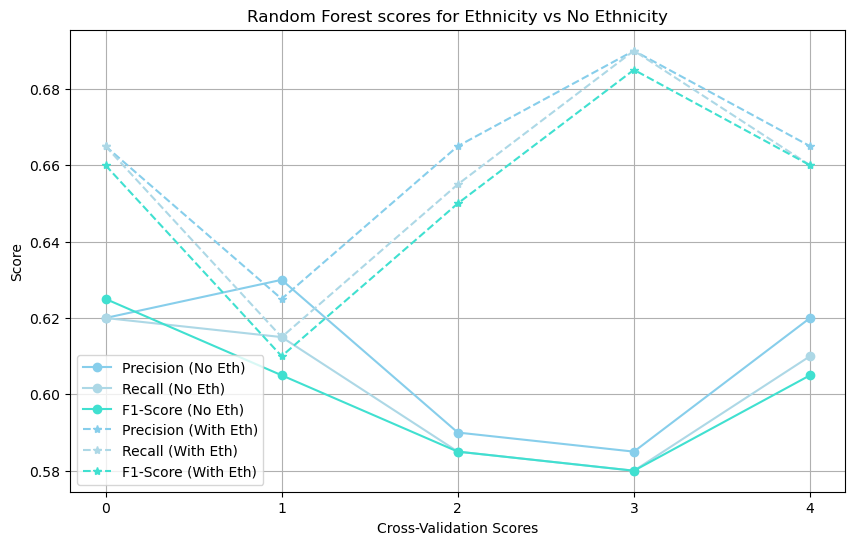

In [34]:
import matplotlib.pyplot as plt
import numpy as np


# Cross-validation scores without ethnicity - Label 0
cv_label0_precision = [0.61, 0.59, 0.58, 0.58, 0.59]
cv_label0_recall = [0.66, 0.78, 0.64, 0.6, 0.73]
cv_label0_f1_score = [0.64, 0.67, 0.61, 0.59, 0.65]

# Cross-validation scores without ethnicity - Label 1
cv_label1_precision = [0.63, 0.67, 0.6, 0.59, 0.65]
cv_label1_recall = [0.58, 0.45, 0.53, 0.56, 0.49]
cv_label1_f1_score = [0.61, 0.54, 0.56, 0.57, 0.56]

# Calculate the overall scores for each fold
overall_no_eth_precision = [(cv_label0_precision[i] + cv_label1_precision[i]) / 2 for i in range(5)]
overall_no_eth_recall = [(cv_label0_recall[i] + cv_label1_recall[i]) / 2 for i in range(5)]
overall_no_eth_f1_score = [(cv_label0_f1_score[i] + cv_label1_f1_score[i]) / 2 for i in range(5)]

# Cross-validation scores with ethnicity - Label 0
cv_eth_label0_precision = [0.66, 0.6, 0.62, 0.66, 0.65]
cv_eth_label0_recall = [0.69, 0.72, 0.79, 0.76, 0.72]
cv_eth_label0_f1_score = [0.67, 0.65, 0.7, 0.71, 0.68]

# Cross-validation scores with ethnicity - Label 1
cv_eth_label1_precision = [0.67, 0.65, 0.71, 0.72, 0.68]
cv_eth_label1_recall = [0.64, 0.51, 0.52, 0.62, 0.6]
cv_eth_label1_f1_score = [0.65, 0.57, 0.6, 0.66, 0.64]

# Calculate the overall scores for each fold
overall_eth_precision = [(cv_eth_label0_precision[i] + cv_eth_label1_precision[i]) / 2 for i in range(5)]
overall_eth_recall = [(cv_eth_label0_recall[i] + cv_eth_label1_recall[i]) / 2 for i in range(5)]
overall_eth_f1_score = [(cv_eth_label0_f1_score[i] + cv_eth_label1_f1_score[i]) / 2 for i in range(5)]

# Set the x-axis positions for the metrics
x = np.arange(5)

# Plot the mean scores
plt.figure(figsize=(10, 6))
plt.plot(x, overall_no_eth_precision, marker='o', label='Precision (No Eth)',color='skyblue')
plt.plot(x, overall_no_eth_recall, marker='o', label='Recall (No Eth)',color='lightblue')
plt.plot(x, overall_no_eth_f1_score, marker='o', label='F1-Score (No Eth)',color='turquoise')
plt.plot(x, overall_eth_precision, marker='*', label='Precision (With Eth)',color='skyblue', linestyle='dashed')
plt.plot(x, overall_eth_recall, marker='*', label='Recall (With Eth)',color='lightblue', linestyle='dashed')
plt.plot(x, overall_eth_f1_score, marker='*', label='F1-Score (With Eth)',color='turquoise', linestyle='dashed')

plt.xlabel('Cross-Validation Scores')
plt.ylabel('Score')
plt.title('Random Forest scores for Ethnicity vs No Ethnicity')
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.show()

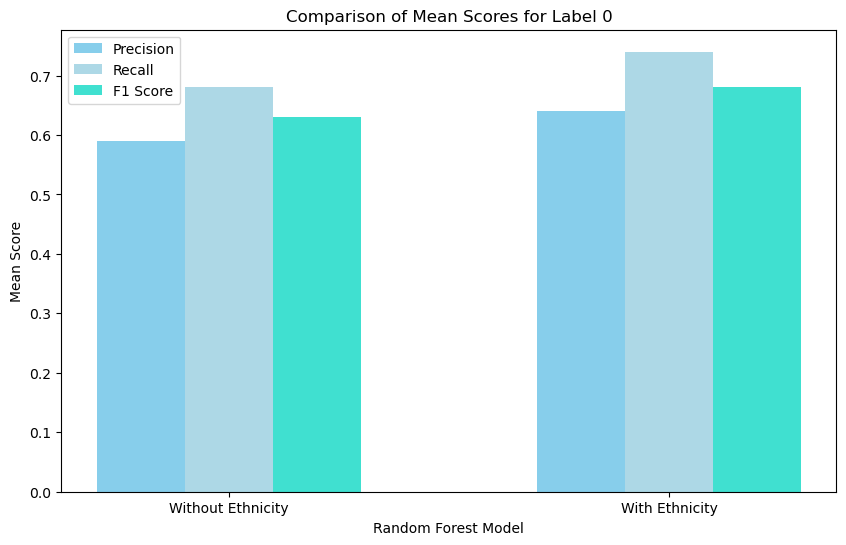

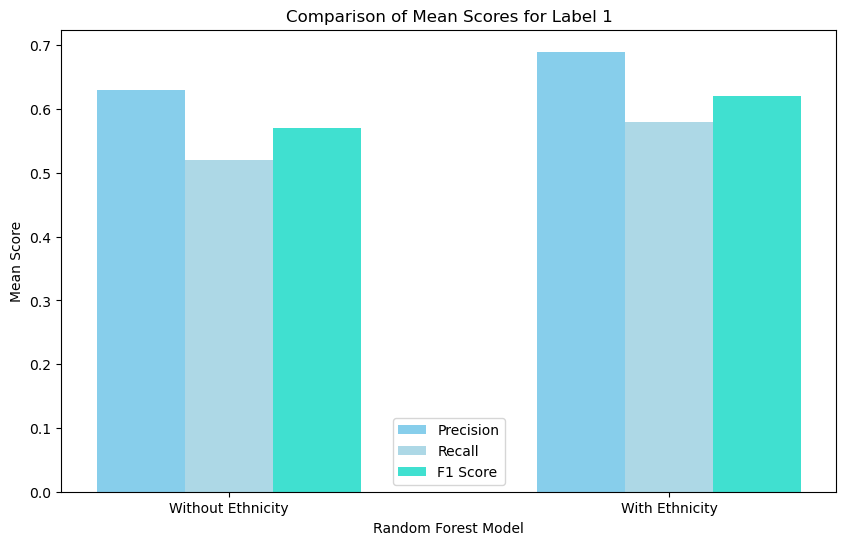

In [16]:
# Mean scores without ethnicity
no_eth_label0_precision_mean = 0.59
no_eth_label0_recall_mean = 0.68
no_eth_label0_f1_score_mean = 0.63

no_eth_label1_precision_mean = 0.63
no_eth_label1_recall_mean = 0.52
no_eth_label1_f1_score_mean = 0.57

# Mean scores with ethnicity
eth_label0_precision_mean = 0.64
eth_label0_recall_mean = 0.74
eth_label0_f1_score_mean = 0.68

eth_label1_precision_mean = 0.69
eth_label1_recall_mean = 0.58
eth_label1_f1_score_mean = 0.62

# Set the x-axis positions for the bars
x = np.arange(2)

# Set the width of each bar
bar_width = 0.2

# Plot the bar plots
plt.figure(figsize=(10, 6))
plt.bar(x, [no_eth_label0_precision_mean, eth_label0_precision_mean], width=bar_width, label='Precision',color='skyblue')
plt.bar(x + bar_width, [no_eth_label0_recall_mean, eth_label0_recall_mean], width=bar_width, label='Recall',color='lightblue')
plt.bar(x + 2 * bar_width, [no_eth_label0_f1_score_mean, eth_label0_f1_score_mean], width=bar_width, label='F1 Score',color='turquoise')

plt.xticks(x + bar_width, ['Without Ethnicity', 'With Ethnicity'])
plt.xlabel('Random Forest Model')
plt.ylabel('Mean Score')
plt.title('Comparison of Mean Scores for Label 0')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(x, [no_eth_label1_precision_mean, eth_label1_precision_mean], width=bar_width, label='Precision',color='skyblue')
plt.bar(x + bar_width, [no_eth_label1_recall_mean, eth_label1_recall_mean], width=bar_width, label='Recall',color='lightblue')
plt.bar(x + 2 * bar_width, [no_eth_label1_f1_score_mean, eth_label1_f1_score_mean], width=bar_width, label='F1 Score',color='turquoise')

plt.xticks(x + bar_width, ['Without Ethnicity', 'With Ethnicity'])
plt.legend()
plt.xlabel('Random Forest Model')
plt.ylabel('Mean Score')
plt.title('Comparison of Mean Scores for Label 1')
plt.show()

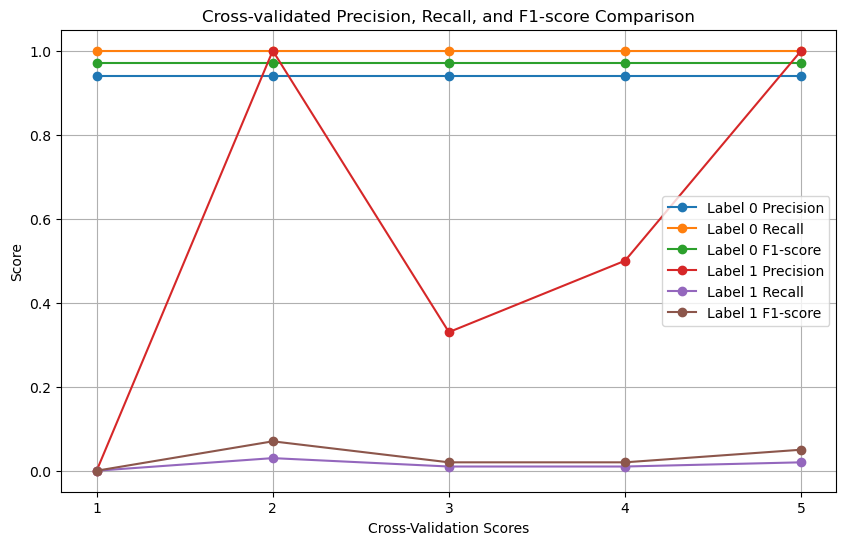

In [20]:
# Define the cross-validated precision, recall, and F1-score for label 0
label0_precision = [0.94, 0.94, 0.94, 0.94, 0.94]
label0_recall = [1.0, 1.0, 1.0, 1.0, 1.0]
label0_f1_score = [0.97, 0.97, 0.97, 0.97, 0.97]

# Define the cross-validated precision, recall, and F1-score for label 1
label1_precision = [0.0, 1.0, 0.33, 0.5, 1.0]
label1_recall = [0.0, 0.03, 0.01, 0.01, 0.02]
label1_f1_score = [0.0, 0.07, 0.02, 0.02, 0.05]

# Set the x-axis values for the cross folds
x = range(1, 6)

# Create the line plot for label 0
plt.figure(figsize=(10, 6))
plt.plot(x, label0_precision, marker='o', label='Label 0 Precision')
plt.plot(x, label0_recall, marker='o', label='Label 0 Recall')
plt.plot(x, label0_f1_score, marker='o', label='Label 0 F1-score')

# Create the line plot for label 1
plt.plot(x, label1_precision, marker='o', label='Label 1 Precision')
plt.plot(x, label1_recall, marker='o', label='Label 1 Recall')
plt.plot(x, label1_f1_score, marker='o', label='Label 1 F1-score')


plt.xlabel('Cross-Validation Scores')
plt.ylabel('Score')
plt.title('Cross-validated Precision, Recall, and F1-score Comparison')
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.show()


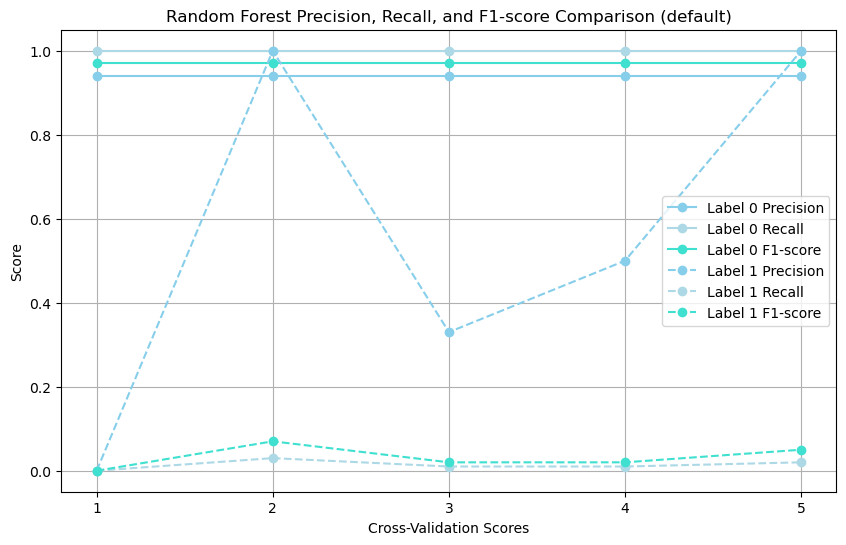

In [31]:
# Define the cross-validated precision, recall, and F1-score for label 0
label0_precision = [0.94, 0.94, 0.94, 0.94, 0.94]
label0_recall = [1.0, 1.0, 1.0, 1.0, 1.0]
label0_f1_score = [0.97, 0.97, 0.97, 0.97, 0.97]

# Define the cross-validated precision, recall, and F1-score for label 1
label1_precision = [0.0, 1.0, 0.33, 0.5, 1.0]
label1_recall = [0.0, 0.03, 0.01, 0.01, 0.02]
label1_f1_score = [0.0, 0.07, 0.02, 0.02, 0.05]

# Set the x-axis values for the cross folds
x = range(1, 6)

# Create the line plot for label 0
plt.figure(figsize=(10, 6))
plt.plot(x, label0_precision, marker='o', label='Label 0 Precision', color='skyblue')
plt.plot(x, label0_recall, marker='o', label='Label 0 Recall', color='lightblue')
plt.plot(x, label0_f1_score, marker='o', label='Label 0 F1-score', color='turquoise')

# Create the line plot for label 1
plt.plot(x, label1_precision, marker='o', label='Label 1 Precision', color='skyblue', linestyle='dashed')
plt.plot(x, label1_recall, marker='o', label='Label 1 Recall', color='lightblue', linestyle='dashed')
plt.plot(x, label1_f1_score, marker='o', label='Label 1 F1-score', color='turquoise', linestyle='dashed')

plt.xlabel('Cross-Validation Scores')
plt.ylabel('Score')
plt.title('Random Forest Precision, Recall, and F1-score Comparison (default)')
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.show()


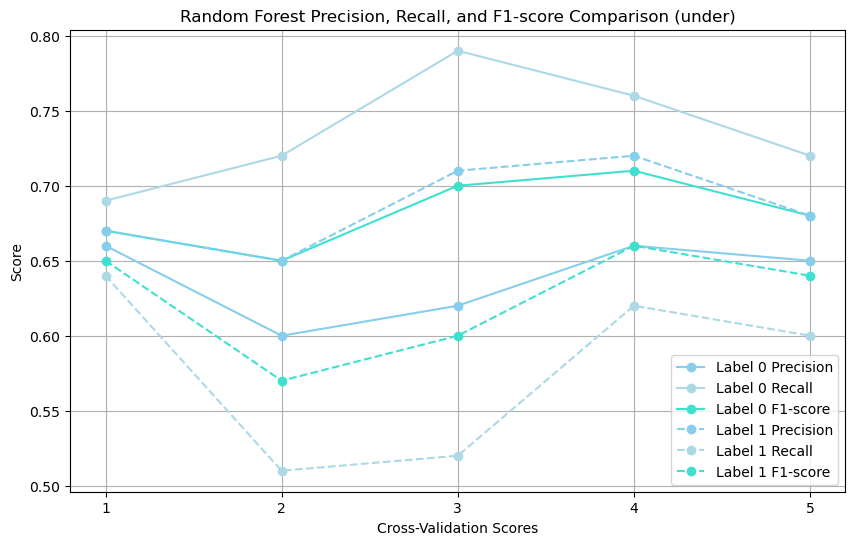

In [32]:
# Define the cross-validated precision, recall, and F1-score for label 0
label0_precision = [0.66, 0.6, 0.62, 0.66, 0.65]
label0_recall = [0.69, 0.72, 0.79, 0.76, 0.72]
label0_f1_score = [0.67, 0.65, 0.7, 0.71, 0.68]

# Define the cross-validated precision, recall, and F1-score for label 1
label1_precision = [0.67, 0.65, 0.71, 0.72, 0.68]
label1_recall = [0.64, 0.51, 0.52, 0.62, 0.6]
label1_f1_score = [0.65, 0.57, 0.6, 0.66, 0.64]

# Set the x-axis values for the cross folds
x = range(1, 6)

# Create the line plot for label 0
plt.figure(figsize=(10, 6))
plt.plot(x, label0_precision, marker='o', label='Label 0 Precision', color='skyblue')
plt.plot(x, label0_recall, marker='o', label='Label 0 Recall', color='lightblue')
plt.plot(x, label0_f1_score, marker='o', label='Label 0 F1-score', color='turquoise')

# Create the line plot for label 1
plt.plot(x, label1_precision, marker='o', label='Label 1 Precision', color='skyblue', linestyle='dashed')
plt.plot(x, label1_recall, marker='o', label='Label 1 Recall', color='lightblue', linestyle='dashed')
plt.plot(x, label1_f1_score, marker='o', label='Label 1 F1-score', color='turquoise', linestyle='dashed')

plt.xlabel('Cross-Validation Scores')
plt.ylabel('Score')
plt.title('Random Forest Precision, Recall, and F1-score Comparison (under)')
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.show()


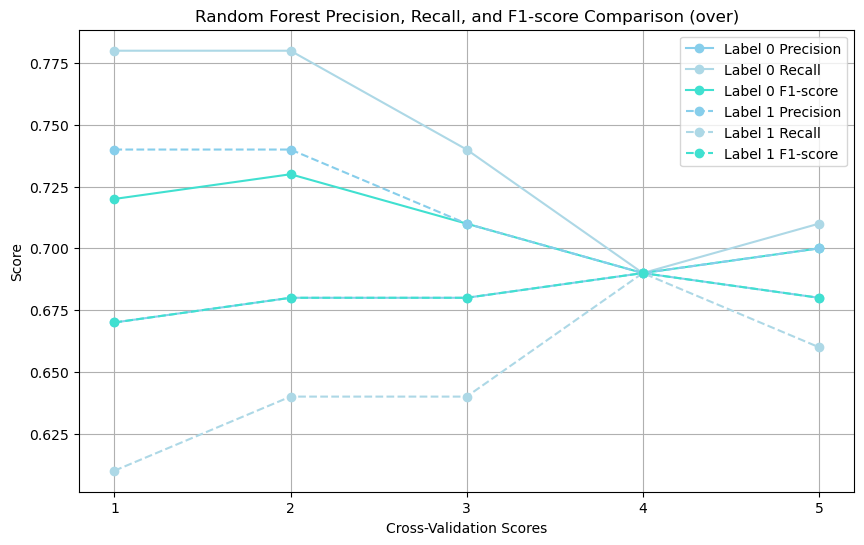

In [33]:
# Define the cross-validated precision, recall, and F1-score for label 0
label0_precision = [0.67, 0.68, 0.68, 0.69, 0.68]
label0_recall = [0.78, 0.78, 0.74, 0.69, 0.71]
label0_f1_score = [0.72, 0.73, 0.71, 0.69, 0.7]

# Define the cross-validated precision, recall, and F1-score for label 1
label1_precision = [0.74, 0.74, 0.71, 0.69, 0.7]
label1_recall = [0.61, 0.64, 0.64, 0.69, 0.66]
label1_f1_score = [0.67, 0.68, 0.68, 0.69, 0.68]

# Set the x-axis values for the cross folds
x = range(1, 6)

# Create the line plot for label 0
plt.figure(figsize=(10, 6))
plt.plot(x, label0_precision, marker='o', label='Label 0 Precision', color='skyblue')
plt.plot(x, label0_recall, marker='o', label='Label 0 Recall', color='lightblue')
plt.plot(x, label0_f1_score, marker='o', label='Label 0 F1-score', color='turquoise')

# Create the line plot for label 1
plt.plot(x, label1_precision, marker='o', label='Label 1 Precision', color='skyblue', linestyle='dashed')
plt.plot(x, label1_recall, marker='o', label='Label 1 Recall', color='lightblue', linestyle='dashed')
plt.plot(x, label1_f1_score, marker='o', label='Label 1 F1-score', color='turquoise', linestyle='dashed')

plt.xlabel('Cross-Validation Scores')
plt.ylabel('Score')
plt.title('Random Forest Precision, Recall, and F1-score Comparison (over)')
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.show()



#### Lab Plots

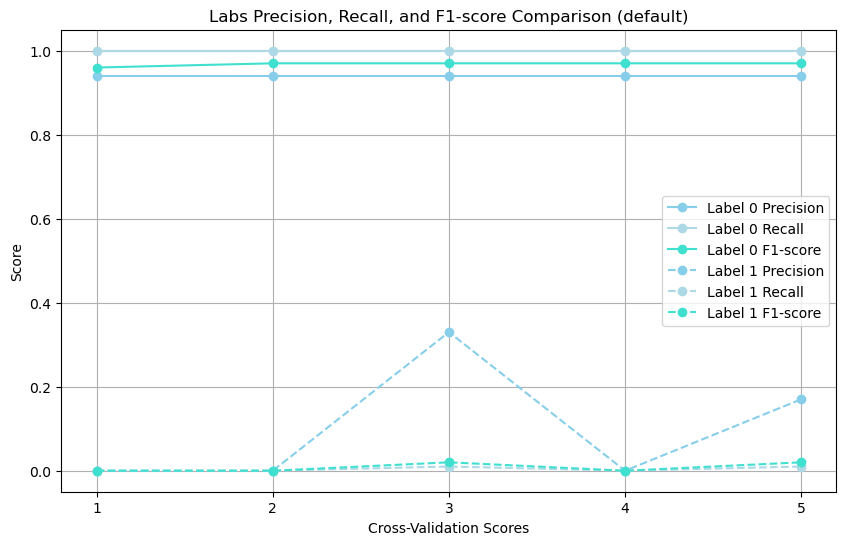

In [35]:
# Define the cross-validated precision, recall, and F1-score for label 0
label0_precision = [0.94, 0.94, 0.94, 0.94, 0.94]
label0_recall = [1.0, 1.0, 1.0, 1.0, 1.0]
label0_f1_score = [0.96, 0.97, 0.97, 0.97, 0.97]

# Define the cross-validated precision, recall, and F1-score for label 1
label1_precision =[0.0, 0.0, 0.33, 0.0, 0.17]
label1_recall = [0.0, 0.0, 0.01, 0.0, 0.01]
label1_f1_score =  [0.0, 0.0, 0.02, 0.0, 0.02]

# Set the x-axis values for the cross folds
x = range(1, 6)

# Create the line plot for label 0
plt.figure(figsize=(10, 6))
plt.plot(x, label0_precision, marker='o', label='Label 0 Precision', color='skyblue')
plt.plot(x, label0_recall, marker='o', label='Label 0 Recall', color='lightblue')
plt.plot(x, label0_f1_score, marker='o', label='Label 0 F1-score', color='turquoise')

# Create the line plot for label 1
plt.plot(x, label1_precision, marker='o', label='Label 1 Precision', color='skyblue', linestyle='dashed')
plt.plot(x, label1_recall, marker='o', label='Label 1 Recall', color='lightblue', linestyle='dashed')
plt.plot(x, label1_f1_score, marker='o', label='Label 1 F1-score', color='turquoise', linestyle='dashed')

plt.xlabel('Cross-Validation Scores')
plt.ylabel('Score')
plt.title('Labs Precision, Recall, and F1-score Comparison (default)')
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.show()


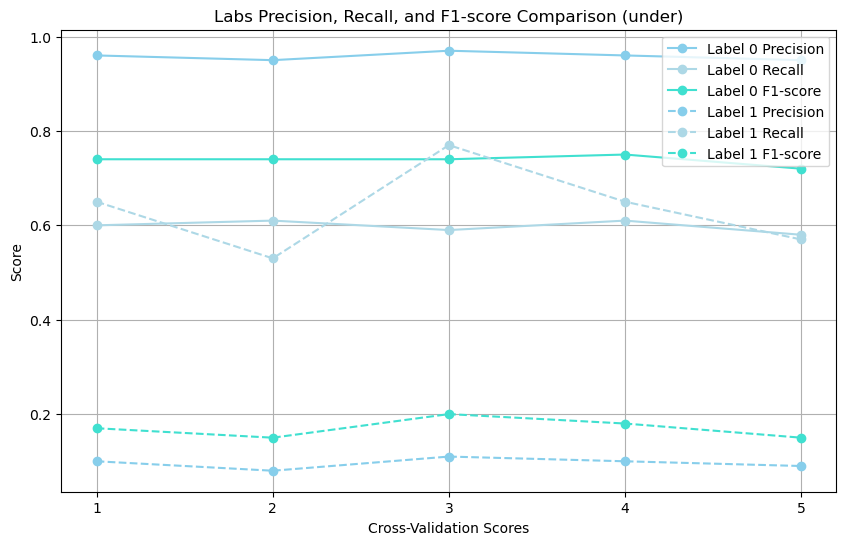

In [36]:
# Define the cross-validated precision, recall, and F1-score for label 0
label0_precision = [0.96, 0.95, 0.97, 0.96, 0.95]
label0_recall = [0.6, 0.61, 0.59, 0.61, 0.58]
label0_f1_score = [0.74, 0.74, 0.74, 0.75, 0.72]

# Define the cross-validated precision, recall, and F1-score for label 1
label1_precision = [0.1, 0.08, 0.11, 0.1, 0.09]
label1_recall = [0.65, 0.53, 0.77, 0.65, 0.57]
label1_f1_score =  [0.17, 0.15, 0.2, 0.18, 0.15]

# Set the x-axis values for the cross folds
x = range(1, 6)

# Create the line plot for label 0
plt.figure(figsize=(10, 6))
plt.plot(x, label0_precision, marker='o', label='Label 0 Precision', color='skyblue')
plt.plot(x, label0_recall, marker='o', label='Label 0 Recall', color='lightblue')
plt.plot(x, label0_f1_score, marker='o', label='Label 0 F1-score', color='turquoise')

# Create the line plot for label 1
plt.plot(x, label1_precision, marker='o', label='Label 1 Precision', color='skyblue', linestyle='dashed')
plt.plot(x, label1_recall, marker='o', label='Label 1 Recall', color='lightblue', linestyle='dashed')
plt.plot(x, label1_f1_score, marker='o', label='Label 1 F1-score', color='turquoise', linestyle='dashed')

plt.xlabel('Cross-Validation Scores')
plt.ylabel('Score')
plt.title('Labs Precision, Recall, and F1-score Comparison (under)')
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.show()



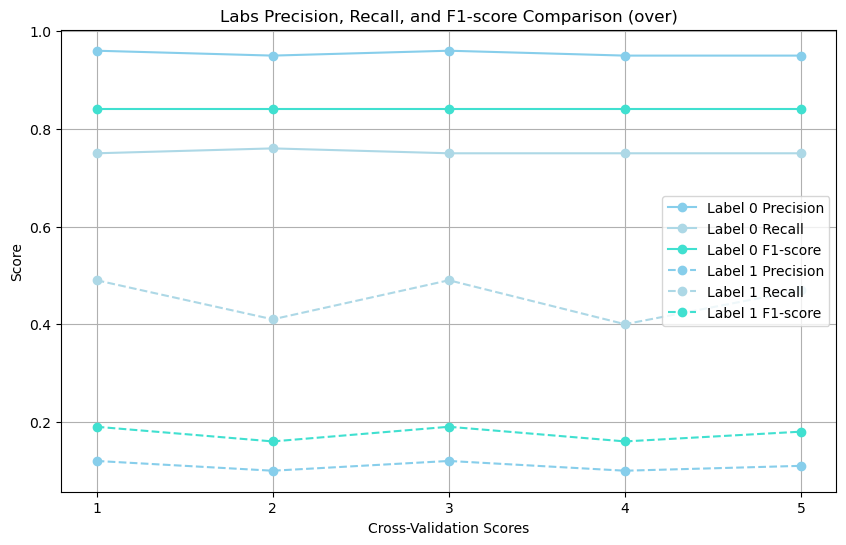

In [37]:
# Define the cross-validated precision, recall, and F1-score for label 0
label0_precision = [0.96, 0.95, 0.96, 0.95, 0.95]
label0_recall = [0.75, 0.76, 0.75, 0.75, 0.75]
label0_f1_score =  [0.84, 0.84, 0.84, 0.84, 0.84]

# Define the cross-validated precision, recall, and F1-score for label 1
label1_precision = [0.12, 0.1, 0.12, 0.1, 0.11]
label1_recall = [0.49, 0.41, 0.49, 0.4, 0.47]
label1_f1_score =  [0.19, 0.16, 0.19, 0.16, 0.18]

# Set the x-axis values for the cross folds
x = range(1, 6)

# Create the line plot for label 0
plt.figure(figsize=(10, 6))
plt.plot(x, label0_precision, marker='o', label='Label 0 Precision', color='skyblue')
plt.plot(x, label0_recall, marker='o', label='Label 0 Recall', color='lightblue')
plt.plot(x, label0_f1_score, marker='o', label='Label 0 F1-score', color='turquoise')

# Create the line plot for label 1
plt.plot(x, label1_precision, marker='o', label='Label 1 Precision', color='skyblue', linestyle='dashed')
plt.plot(x, label1_recall, marker='o', label='Label 1 Recall', color='lightblue', linestyle='dashed')
plt.plot(x, label1_f1_score, marker='o', label='Label 1 F1-score', color='turquoise', linestyle='dashed')

plt.xlabel('Cross-Validation Scores')
plt.ylabel('Score')
plt.title('Labs Precision, Recall, and F1-score Comparison (over)')
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.show()



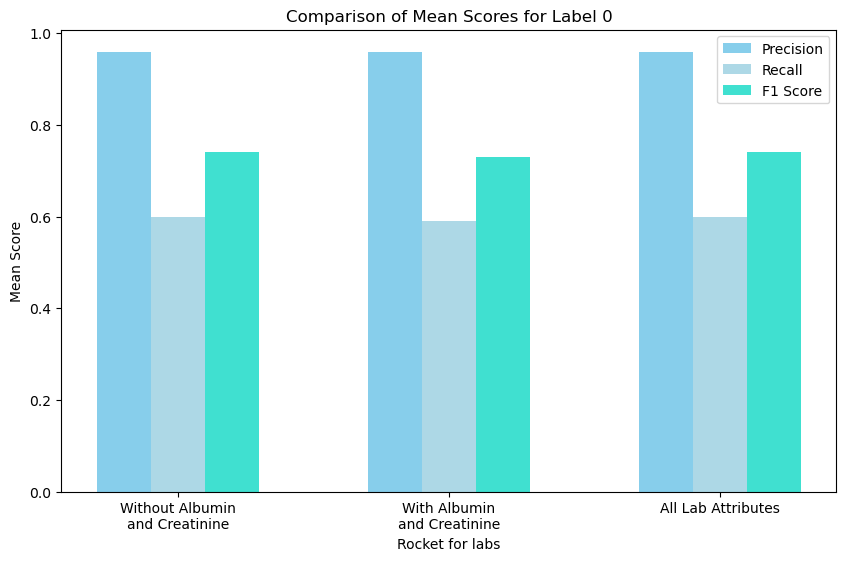

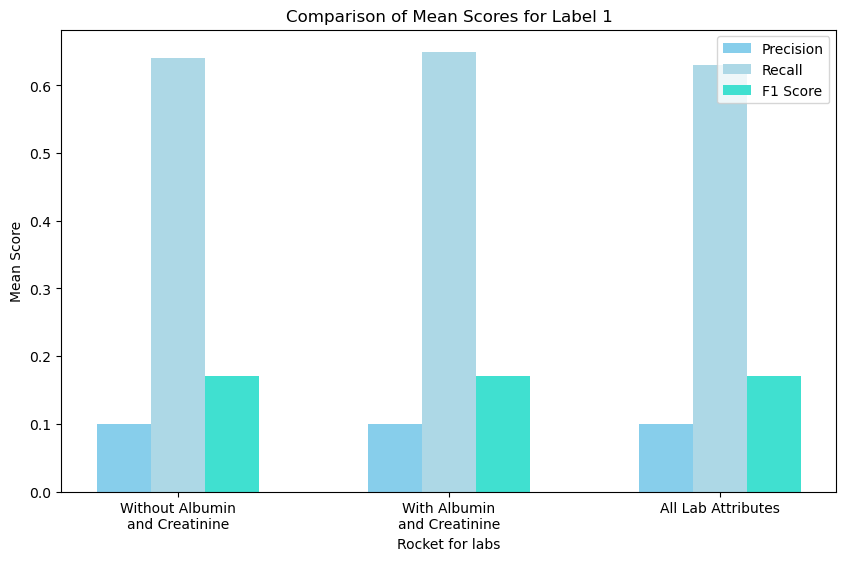

In [40]:
# Mean scores without albumin and creatinine
no_alb_crea_label0_precision_mean = 0.96
no_alb_crea_label0_recall_mean = 0.6
no_alb_crea_label0_f1_score_mean = 0.74

no_alb_crea_label1_precision_mean = 0.1
no_alb_crea_label1_recall_mean = 0.64
no_alb_crea_label1_f1_score_mean = 0.17

# Mean scores with only albumin and creatinine
alb_crea_label0_precision_mean = 0.96
alb_crea_label0_recall_mean = 0.59
alb_crea_label0_f1_score_mean = 0.73

alb_crea_label1_precision_mean = 0.1
alb_crea_label1_recall_mean = 0.65
alb_crea_label1_f1_score_mean = 0.17

# Mean scores with all lab attributes
all_lab_label0_precision_mean = 0.96
all_lab_label0_recall_mean = 0.6
all_lab_label0_f1_score_mean = 0.74

all_lab_label1_precision_mean = 0.1
all_lab_label1_recall_mean = 0.63
all_lab_label1_f1_score_mean = 0.17

# Set the x-axis positions for the bars
x = np.arange(3)

# Set the width of each bar
bar_width = 0.2

# Plot the bar plots for label 0
plt.figure(figsize=(10, 6))
plt.bar(x, [no_alb_crea_label0_precision_mean, alb_crea_label0_precision_mean, all_lab_label0_precision_mean], width=bar_width, label='Precision', color='skyblue')
plt.bar(x + bar_width, [no_alb_crea_label0_recall_mean, alb_crea_label0_recall_mean, all_lab_label0_recall_mean], width=bar_width, label='Recall', color='lightblue')
plt.bar(x + 2 * bar_width, [no_alb_crea_label0_f1_score_mean, alb_crea_label0_f1_score_mean, all_lab_label0_f1_score_mean], width=bar_width, label='F1 Score', color='turquoise')

plt.xticks(x + bar_width, ['Without Albumin\nand Creatinine', 'With Albumin\nand Creatinine', 'All Lab Attributes'])
plt.xlabel('Rocket for labs')
plt.ylabel('Mean Score')
plt.title('Comparison of Mean Scores for Label 0')
plt.legend()
plt.show()

# Plot the bar plots for label 1
plt.figure(figsize=(10, 6))
plt.bar(x, [no_alb_crea_label1_precision_mean, alb_crea_label1_precision_mean, all_lab_label1_precision_mean], width=bar_width, label='Precision', color='skyblue')
plt.bar(x + bar_width, [no_alb_crea_label1_recall_mean, alb_crea_label1_recall_mean, all_lab_label1_recall_mean], width=bar_width, label='Recall', color='lightblue')
plt.bar(x + 2 * bar_width, [no_alb_crea_label1_f1_score_mean, alb_crea_label1_f1_score_mean, all_lab_label1_f1_score_mean], width=bar_width, label='F1 Score', color='turquoise')

plt.xticks(x + bar_width, ['Without Albumin\nand Creatinine', 'With Albumin\nand Creatinine', 'All Lab Attributes'])
plt.xlabel('Rocket for labs')
plt.ylabel('Mean Score')
plt.title('Comparison of Mean Scores for Label 1')
plt.legend()
plt.show()

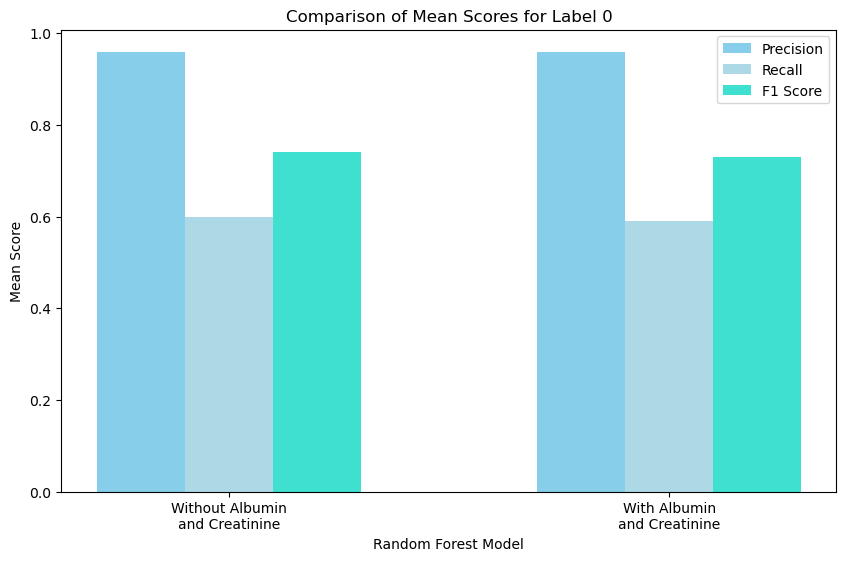

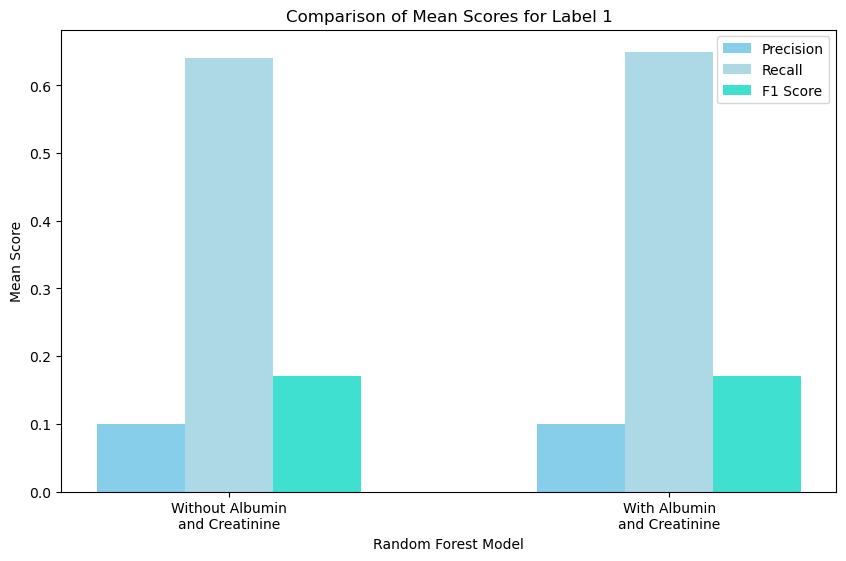

In [41]:
# Mean scores without albumin and creatinine
no_alb_crea_label0_precision_mean = 0.96
no_alb_crea_label0_recall_mean = 0.6
no_alb_crea_label0_f1_score_mean = 0.74

no_alb_crea_label1_precision_mean = 0.1
no_alb_crea_label1_recall_mean = 0.64
no_alb_crea_label1_f1_score_mean = 0.17

# Mean scores with only albumin and creatinine
alb_crea_label0_precision_mean = 0.96
alb_crea_label0_recall_mean = 0.59
alb_crea_label0_f1_score_mean = 0.73

alb_crea_label1_precision_mean = 0.1
alb_crea_label1_recall_mean = 0.65
alb_crea_label1_f1_score_mean = 0.17

# Set the x-axis positions for the bars
x = np.arange(2)

# Set the width of each bar
bar_width = 0.2

# Plot the bar plots for label 0
plt.figure(figsize=(10, 6))
plt.bar(x, [no_alb_crea_label0_precision_mean, alb_crea_label0_precision_mean], width=bar_width, label='Precision', color='skyblue')
plt.bar(x + bar_width, [no_alb_crea_label0_recall_mean, alb_crea_label0_recall_mean], width=bar_width, label='Recall', color='lightblue')
plt.bar(x + 2 * bar_width, [no_alb_crea_label0_f1_score_mean, alb_crea_label0_f1_score_mean], width=bar_width, label='F1 Score', color='turquoise')

plt.xticks(x + bar_width, ['Without Albumin\nand Creatinine', 'With Albumin\nand Creatinine'])
plt.xlabel('Random Forest Model')
plt.ylabel('Mean Score')
plt.title('Comparison of Mean Scores for Label 0')
plt.legend()
plt.show()

# Plot the bar plots for label 1
plt.figure(figsize=(10, 6))
plt.bar(x, [no_alb_crea_label1_precision_mean, alb_crea_label1_precision_mean], width=bar_width, label='Precision', color='skyblue')
plt.bar(x + bar_width, [no_alb_crea_label1_recall_mean, alb_crea_label1_recall_mean], width=bar_width, label='Recall', color='lightblue')
plt.bar(x + 2 * bar_width, [no_alb_crea_label1_f1_score_mean, alb_crea_label1_f1_score_mean], width=bar_width, label='F1 Score', color='turquoise')

plt.xticks(x + bar_width, ['Without Albumin\nand Creatinine', 'With Albumin\nand Creatinine'])
plt.xlabel('Random Forest Model')
plt.ylabel('Mean Score')
plt.title('Comparison of Mean Scores for Label 1')
plt.legend()
plt.show()

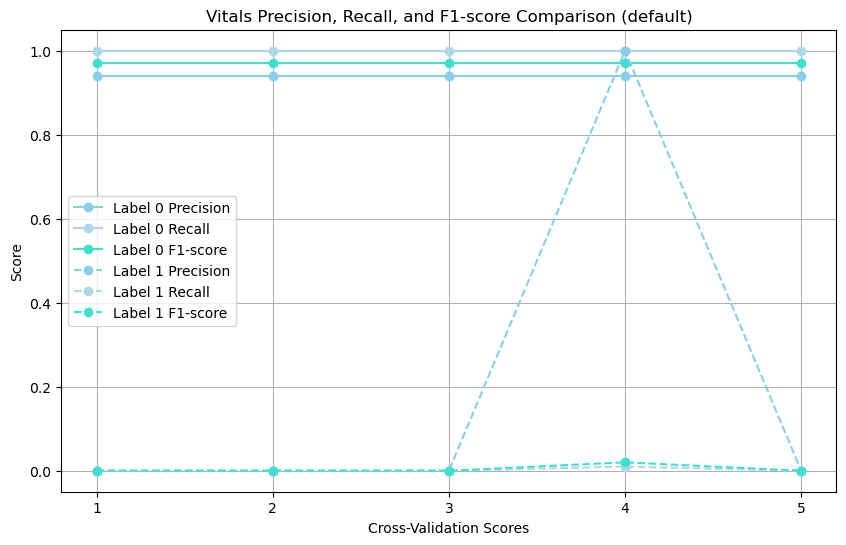

In [42]:
# Define the cross-validated precision, recall, and F1-score for label 0
label0_precision = [0.94, 0.94, 0.94, 0.94, 0.94]
label0_recall = [1.0, 1.0, 1.0, 1.0, 1.0]
label0_f1_score = [0.97, 0.97, 0.97, 0.97, 0.97]

# Define the cross-validated precision, recall, and F1-score for label 1
label1_precision = [0.0, 0.0, 0.0, 1.0, 0.0]
label1_recall = [0.0, 0.0, 0.0, 0.01, 0.0]
label1_f1_score = [0.0, 0.0, 0.0, 0.02, 0.0]

# Set the x-axis values for the cross folds
x = range(1, 6)

# Create the line plot for label 0
plt.figure(figsize=(10, 6))
plt.plot(x, label0_precision, marker='o', label='Label 0 Precision', color='skyblue')
plt.plot(x, label0_recall, marker='o', label='Label 0 Recall', color='lightblue')
plt.plot(x, label0_f1_score, marker='o', label='Label 0 F1-score', color='turquoise')

# Create the line plot for label 1
plt.plot(x, label1_precision, marker='o', label='Label 1 Precision', color='skyblue', linestyle='dashed')
plt.plot(x, label1_recall, marker='o', label='Label 1 Recall', color='lightblue', linestyle='dashed')
plt.plot(x, label1_f1_score, marker='o', label='Label 1 F1-score', color='turquoise', linestyle='dashed')

plt.xlabel('Cross-Validation Scores')
plt.ylabel('Score')
plt.title('Vitals Precision, Recall, and F1-score Comparison (default)')
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.show()


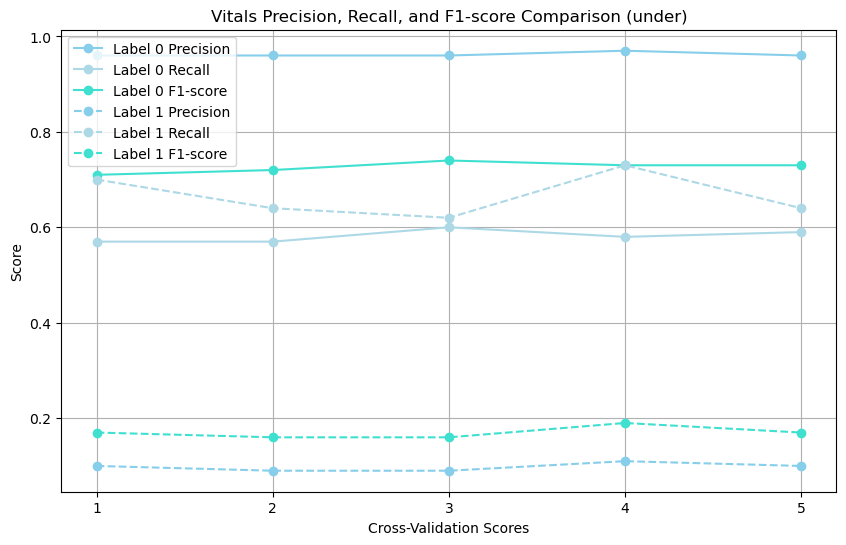

In [43]:
# Define the cross-validated precision, recall, and F1-score for label 0
label0_precision = [0.96, 0.96, 0.96, 0.97, 0.96]
label0_recall = [0.57, 0.57, 0.6, 0.58, 0.59]
label0_f1_score = [0.71, 0.72, 0.74, 0.73, 0.73]

# Define the cross-validated precision, recall, and F1-score for label 1
label1_precision = [0.1, 0.09, 0.09, 0.11, 0.1]
label1_recall = [0.7, 0.64, 0.62, 0.73, 0.64]
label1_f1_score = [0.17, 0.16, 0.16, 0.19, 0.17]


# Set the x-axis values for the cross folds
x = range(1, 6)

# Create the line plot for label 0
plt.figure(figsize=(10, 6))
plt.plot(x, label0_precision, marker='o', label='Label 0 Precision', color='skyblue')
plt.plot(x, label0_recall, marker='o', label='Label 0 Recall', color='lightblue')
plt.plot(x, label0_f1_score, marker='o', label='Label 0 F1-score', color='turquoise')

# Create the line plot for label 1
plt.plot(x, label1_precision, marker='o', label='Label 1 Precision', color='skyblue', linestyle='dashed')
plt.plot(x, label1_recall, marker='o', label='Label 1 Recall', color='lightblue', linestyle='dashed')
plt.plot(x, label1_f1_score, marker='o', label='Label 1 F1-score', color='turquoise', linestyle='dashed')

plt.xlabel('Cross-Validation Scores')
plt.ylabel('Score')
plt.title('Vitals Precision, Recall, and F1-score Comparison (under)')
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.show()


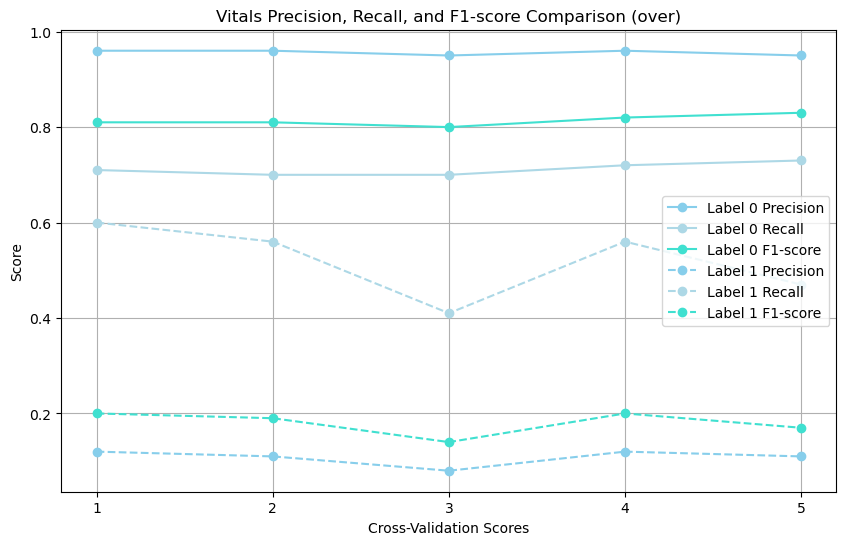

In [45]:
# Define the cross-validated precision, recall, and F1-score for label 0
label0_precision = [0.96, 0.96, 0.95, 0.96, 0.95]
label0_recall = [0.71, 0.7, 0.7, 0.72, 0.73]
label0_f1_score = [0.81, 0.81, 0.8, 0.82, 0.83]

# Define the cross-validated precision, recall, and F1-score for label 1
label1_precision = [0.12, 0.11, 0.08, 0.12, 0.11]
label1_recall = [0.6, 0.56, 0.41, 0.56, 0.47]
label1_f1_score = [0.2, 0.19, 0.14, 0.2, 0.17]



# Set the x-axis values for the cross folds
x = range(1, 6)

# Create the line plot for label 0
plt.figure(figsize=(10, 6))
plt.plot(x, label0_precision, marker='o', label='Label 0 Precision', color='skyblue')
plt.plot(x, label0_recall, marker='o', label='Label 0 Recall', color='lightblue')
plt.plot(x, label0_f1_score, marker='o', label='Label 0 F1-score', color='turquoise')

# Create the line plot for label 1
plt.plot(x, label1_precision, marker='o', label='Label 1 Precision', color='skyblue', linestyle='dashed')
plt.plot(x, label1_recall, marker='o', label='Label 1 Recall', color='lightblue', linestyle='dashed')
plt.plot(x, label1_f1_score, marker='o', label='Label 1 F1-score', color='turquoise', linestyle='dashed')

plt.xlabel('Cross-Validation Scores')
plt.ylabel('Score')
plt.title('Vitals Precision, Recall, and F1-score Comparison (over)')
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.show()


#### Test results comparisions

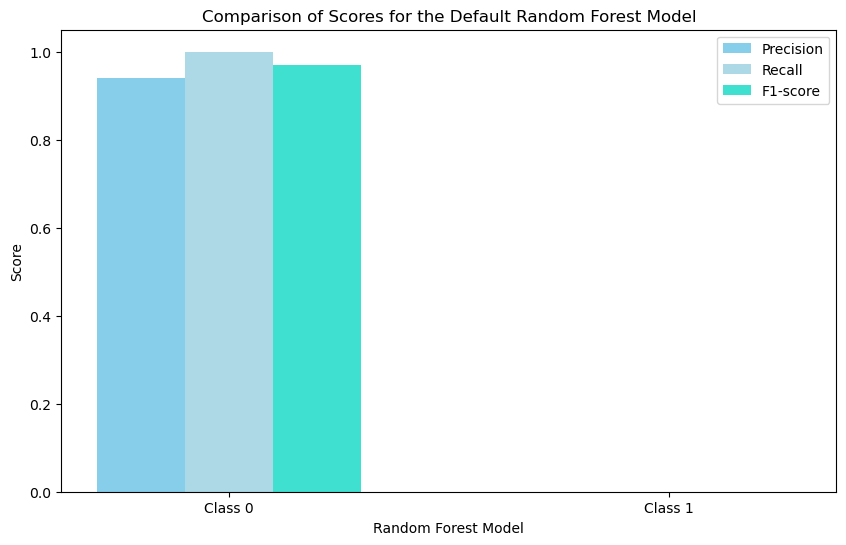

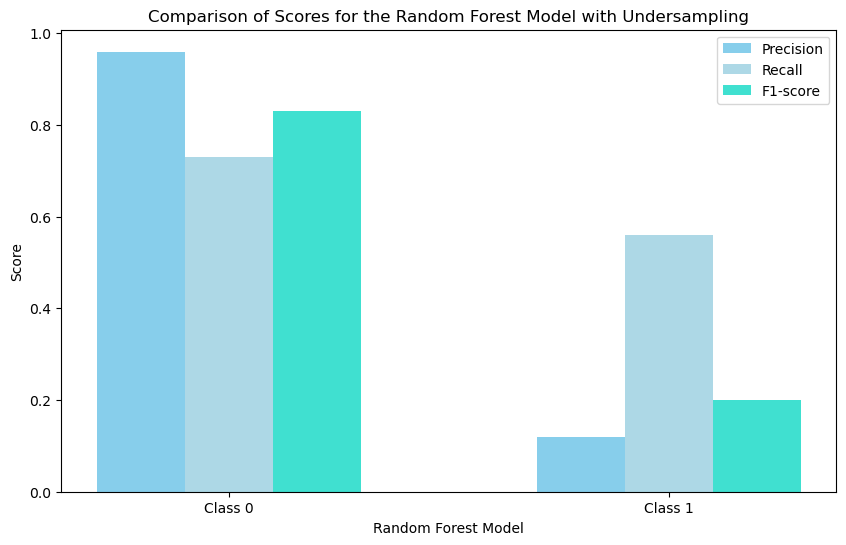

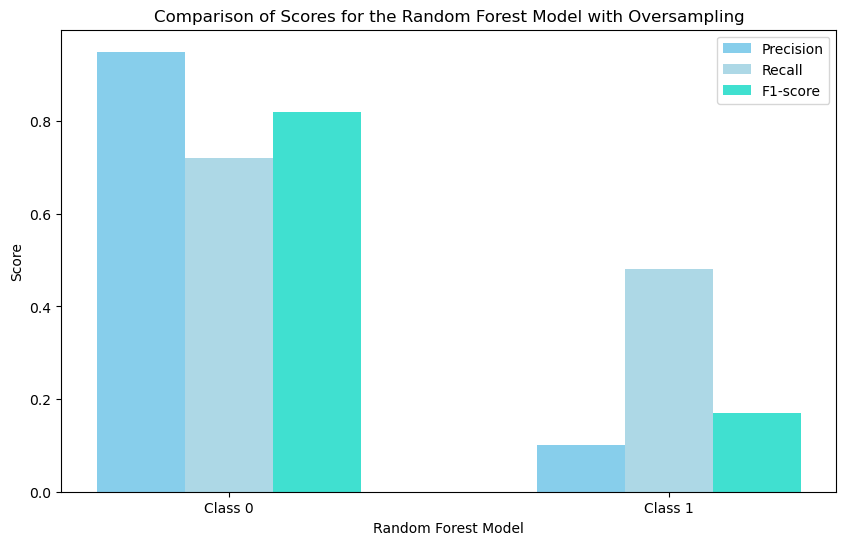

In [46]:
# Define the precision, recall, and F1-score values for each model
default_precision = [0.94, 0.00]
default_recall = [1.00, 0.00]
default_f1_score = [0.97, 0.00]

under_precision = [0.96, 0.12]
under_recall = [0.73, 0.56]
under_f1_score = [0.83, 0.20]

over_precision = [0.95, 0.10]
over_recall = [0.72, 0.48]
over_f1_score = [0.82, 0.17]

# Set the x-axis positions for the bars
x = np.arange(2)

# Set the width of each bar
bar_width = 0.2

# Plot the bar plots
plt.figure(figsize=(10, 6))
plt.bar(x, default_precision, width=bar_width, label='Precision', color='skyblue')
plt.bar(x + bar_width, default_recall, width=bar_width, label='Recall', color='lightblue')
plt.bar(x + 2 * bar_width, default_f1_score, width=bar_width, label='F1-score', color='turquoise')

# Set the x-axis labels and title
plt.xticks(x + bar_width, ['Class 0', 'Class 1'])
plt.xlabel('Random Forest Model')
plt.ylabel('Score')
plt.title('Comparison of Scores for the Default Random Forest Model')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(x, under_precision, width=bar_width, label='Precision', color='skyblue')
plt.bar(x + bar_width, under_recall, width=bar_width, label='Recall', color='lightblue')
plt.bar(x + 2 * bar_width, under_f1_score, width=bar_width, label='F1-score', color='turquoise')

plt.xticks(x + bar_width, ['Class 0', 'Class 1'])
plt.xlabel('Random Forest Model')
plt.ylabel('Score')
plt.title('Comparison of Scores for the Random Forest Model with Undersampling')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(x, over_precision, width=bar_width, label='Precision', color='skyblue')
plt.bar(x + bar_width, over_recall, width=bar_width, label='Recall', color='lightblue')
plt.bar(x + 2 * bar_width, over_f1_score, width=bar_width, label='F1-score', color='turquoise')

plt.xticks(x + bar_width, ['Class 0', 'Class 1'])
plt.xlabel('Random Forest Model')
plt.ylabel('Score')
plt.title('Comparison of Scores for the Random Forest Model with Oversampling')
plt.legend()
plt.show()

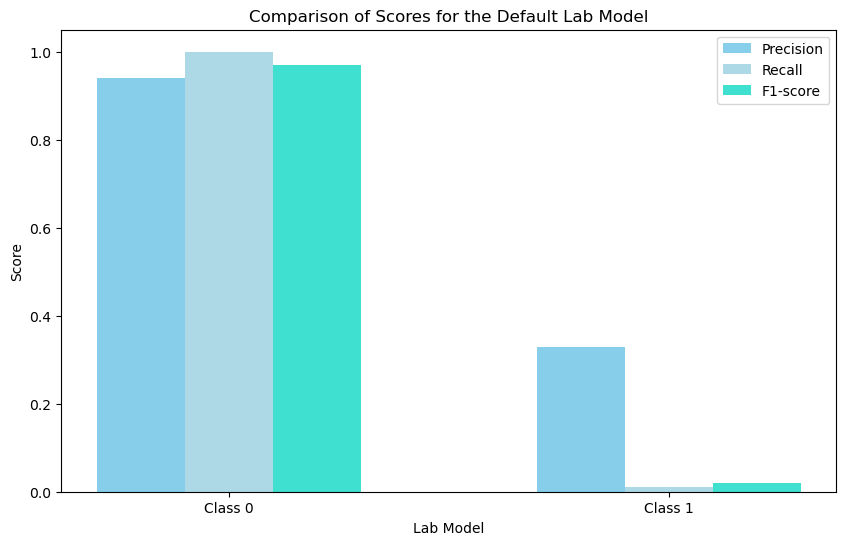

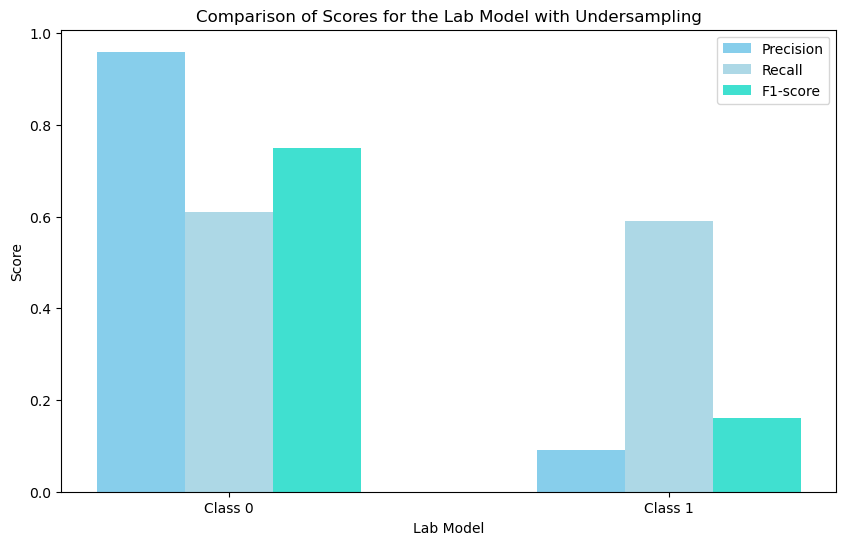

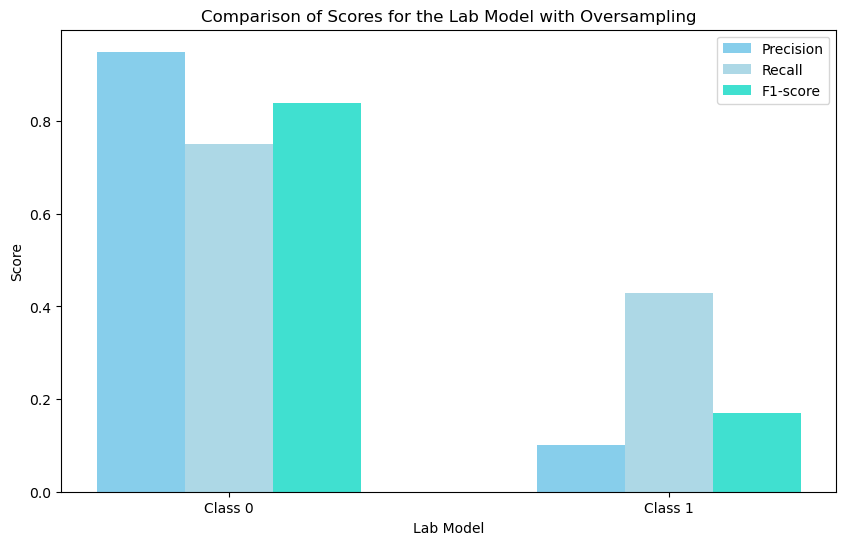

In [47]:
# Define the precision, recall, and F1-score values for each model
default_precision = [0.94, 0.33]
default_recall = [1.00, 0.01]
default_f1_score = [0.97, 0.02]

under_precision = [0.96, 0.09]
under_recall = [0.61, 0.59]
under_f1_score = [0.75, 0.16]

over_precision = [0.95, 0.10]
over_recall = [0.75, 0.43]
over_f1_score = [0.84, 0.17]

# Set the x-axis positions for the bars
x = np.arange(2)

# Set the width of each bar
bar_width = 0.2

# Plot the bar plots
plt.figure(figsize=(10, 6))
plt.bar(x, default_precision, width=bar_width, label='Precision', color='skyblue')
plt.bar(x + bar_width, default_recall, width=bar_width, label='Recall', color='lightblue')
plt.bar(x + 2 * bar_width, default_f1_score, width=bar_width, label='F1-score', color='turquoise')

# Set the x-axis labels and title
plt.xticks(x + bar_width, ['Class 0', 'Class 1'])
plt.xlabel('Lab Model')
plt.ylabel('Score')
plt.title('Comparison of Scores for the Default Lab Model')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(x, under_precision, width=bar_width, label='Precision', color='skyblue')
plt.bar(x + bar_width, under_recall, width=bar_width, label='Recall', color='lightblue')
plt.bar(x + 2 * bar_width, under_f1_score, width=bar_width, label='F1-score', color='turquoise')

plt.xticks(x + bar_width, ['Class 0', 'Class 1'])
plt.xlabel('Lab Model')
plt.ylabel('Score')
plt.title('Comparison of Scores for the Lab Model with Undersampling')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(x, over_precision, width=bar_width, label='Precision', color='skyblue')
plt.bar(x + bar_width, over_recall, width=bar_width, label='Recall', color='lightblue')
plt.bar(x + 2 * bar_width, over_f1_score, width=bar_width, label='F1-score', color='turquoise')

plt.xticks(x + bar_width, ['Class 0', 'Class 1'])
plt.xlabel('Lab Model')
plt.ylabel('Score')
plt.title('Comparison of Scores for the Lab Model with Oversampling')
plt.legend()
plt.show()

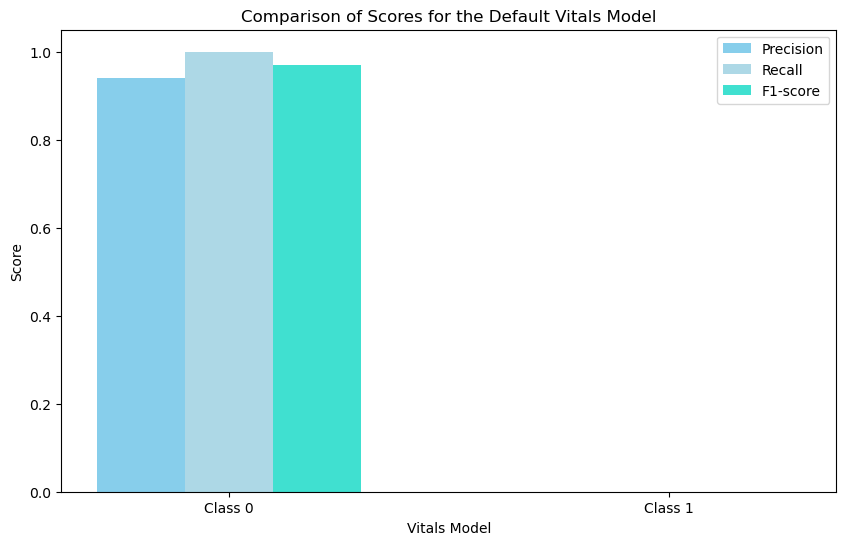

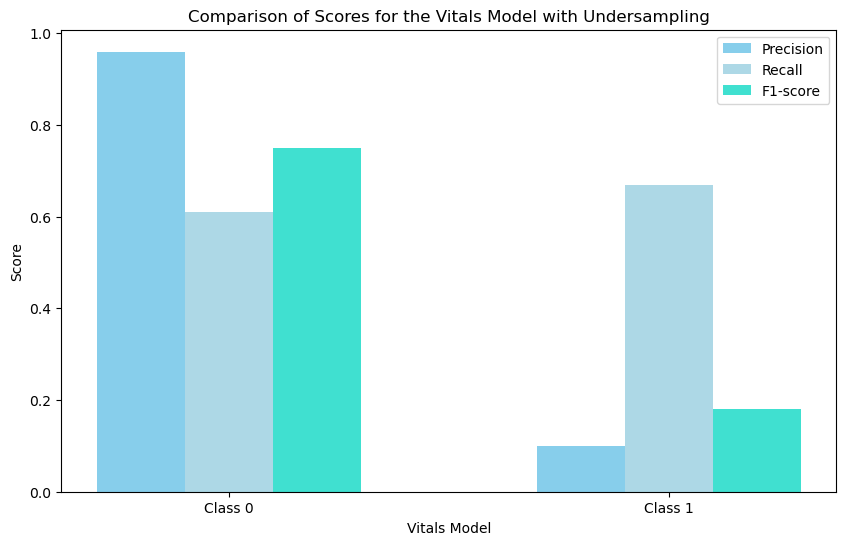

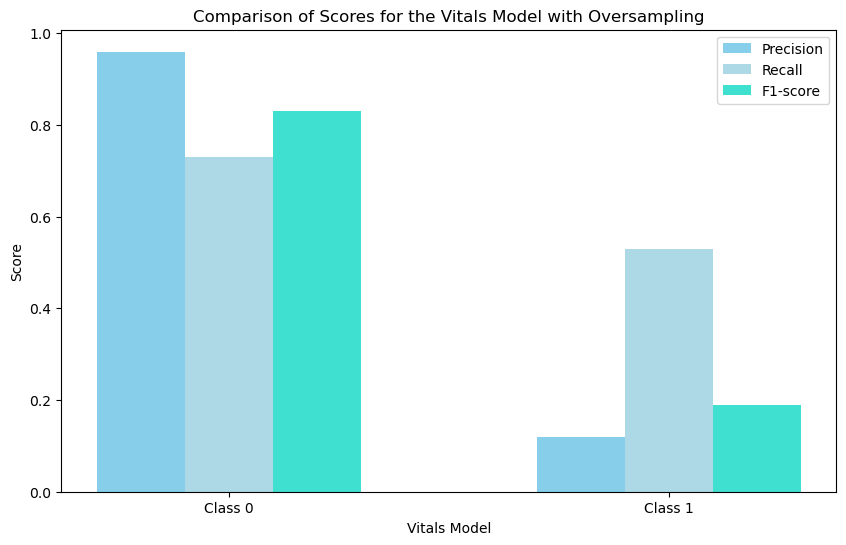

In [48]:
# Define the precision, recall, and F1-score values for each model
default_precision = [0.94, 0.0]
default_recall = [1.00, 0.0]
default_f1_score = [0.97, 0.0]

under_precision = [0.96, 0.10]
under_recall = [0.61, 0.67]
under_f1_score = [0.75, 0.18]

over_precision = [0.96, 0.12]
over_recall = [0.73, 0.53]
over_f1_score = [0.83, 0.19]

# Set the x-axis positions for the bars
x = np.arange(2)

# Set the width of each bar
bar_width = 0.2

# Plot the bar plots
plt.figure(figsize=(10, 6))
plt.bar(x, default_precision, width=bar_width, label='Precision', color='skyblue')
plt.bar(x + bar_width, default_recall, width=bar_width, label='Recall', color='lightblue')
plt.bar(x + 2 * bar_width, default_f1_score, width=bar_width, label='F1-score', color='turquoise')

# Set the x-axis labels and title
plt.xticks(x + bar_width, ['Class 0', 'Class 1'])
plt.xlabel('Vitals Model')
plt.ylabel('Score')
plt.title('Comparison of Scores for the Default Vitals Model')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(x, under_precision, width=bar_width, label='Precision', color='skyblue')
plt.bar(x + bar_width, under_recall, width=bar_width, label='Recall', color='lightblue')
plt.bar(x + 2 * bar_width, under_f1_score, width=bar_width, label='F1-score', color='turquoise')

plt.xticks(x + bar_width, ['Class 0', 'Class 1'])
plt.xlabel('Vitals Model')
plt.ylabel('Score')
plt.title('Comparison of Scores for the Vitals Model with Undersampling')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(x, over_precision, width=bar_width, label='Precision', color='skyblue')
plt.bar(x + bar_width, over_recall, width=bar_width, label='Recall', color='lightblue')
plt.bar(x + 2 * bar_width, over_f1_score, width=bar_width, label='F1-score', color='turquoise')

plt.xticks(x + bar_width, ['Class 0', 'Class 1'])
plt.xlabel('Vitals Model')
plt.ylabel('Score')
plt.title('Comparison of Scores for the Vitals Model with Oversampling')
plt.legend()
plt.show()